## Define maximum layer thicknesses H_max(z)

In [19]:
from mom6_tools.m6plot import xyplot, myStats
import xarray as xr
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from datetime import datetime

%matplotlib inline

In [2]:
# The following parameters must be set accordingly
######################################################
# case name - must be changed for each configuration
grid_name = 'tx2_3v2'
# Path to the grid
case = 'baseline'
# add your name and email address below
author = 'Gustavo Marques (gmarques@ucar.edu)'

In [3]:
# MAX_LAYER_THICKNESS in GFDL's OM4, for comparison purposes

max_h = np.array([400.0, 409.63, 410.32, 410.75, 411.07, 411.32, 411.52, 411.7, 
                  411.86, 412.0, 412.13, 412.24, 412.35, 412.45, 412.54, 412.63, 
                  412.71, 412.79, 412.86, 412.93, 413.0, 413.06, 413.12, 413.18,
                  413.24, 413.29, 413.34, 413.39, 413.44, 413.49, 413.54, 413.58,
                  413.62, 413.67, 413.71, 413.75, 413.78, 413.82, 413.86, 413.9, 
                  413.93, 413.97, 414.0, 414.03, 414.06, 414.1, 414.13, 414.16, 
                  414.19, 414.22, 414.24, 414.27, 414.3, 414.33, 414.35, 414.38, 
                  414.41, 414.43, 414.46, 414.48, 414.51, 414.53, 414.55, 414.58, 
                  414.6, 414.62, 414.65, 414.67, 414.69, 414.71, 414.73, 414.75, 
                  414.77, 414.79, 414.83])

In [4]:
path = '/glade/derecho/scratch/gmarques/g.e23_a16g.GJRAv4.TL319_t232_hycom1_N75.2024.hycom1_exploration_N75/run/'

In [5]:
grd = xr.open_dataset(path + case+'/g.e23_a16g.GJRAv4.TL319_t232_hycom1_N75.2024.hycom1_exploration_N75.mom6.h.static.nc')

In [6]:
# load interfaces zstar
dz = xr.open_dataset(path + case+'/Vertical_coordinate.nc')['Layer']
eta = xr.open_dataset(path + case+'/Vertical_coordinate.nc')['Interface']

In [7]:
dz

<xarray.DataArray 'Layer' (Layer: 75)>
array([1.250000e+00, 3.750000e+00, 6.250000e+00, 8.750000e+00, 1.125000e+01,
       1.375000e+01, 1.625000e+01, 1.875000e+01, 2.125000e+01, 2.375000e+01,
       2.625000e+01, 2.875000e+01, 3.125000e+01, 3.375000e+01, 3.625000e+01,
       3.875000e+01, 4.125000e+01, 4.375000e+01, 4.625000e+01, 4.875000e+01,
       5.125000e+01, 5.375000e+01, 5.625000e+01, 5.875000e+01, 6.125000e+01,
       6.375000e+01, 6.625000e+01, 6.875000e+01, 7.125000e+01, 7.375000e+01,
       7.625000e+01, 7.875000e+01, 8.125000e+01, 8.375000e+01, 8.625000e+01,
       8.876372e+01, 9.130488e+01, 9.387348e+01, 9.646951e+01, 9.909299e+01,
       1.017439e+02, 1.044253e+02, 1.071894e+02, 1.101483e+02, 1.134005e+02,
       1.170264e+02, 1.211252e+02, 1.258301e+02, 1.313104e+02, 1.377775e+02,
       1.455000e+02, 1.548061e+02, 1.661100e+02, 1.799286e+02, 1.968920e+02,
       2.177837e+02, 2.435695e+02, 2.754256e+02, 3.147966e+02, 3.634415e+02,
       4.234923e+02, 4.975393e+02, 5.887171e+02, 7.007975e+02, 8.383154e+02,
       1.006720e+03, 1.212538e+03, 1.463554e+03, 1.769054e+03, 2.140079e+03,
       2.589734e+03, 3.133543e+03, 3.789850e+03, 4.580300e+03, 5.505995e+03])
Coordinates:
  * Layer    (Layer) float64 1.25 3.75 6.25 8.75 ... 3.79e+03 4.58e+03 5.506e+03
Attributes:
    long_name:       Layer z-rho
    units:           meter
    cartesian_axis:  Z
    positive:        up

In [8]:
# load CESM hybrid target densities at interfaces
vgrid = 'hybrid_75layer_zstar2.50m-2020-11-23.nc'
sigma2 = xr.open_dataset(path + 'INPUT/'+vgrid)['sigma2']
dz = xr.open_dataset(path + 'INPUT/'+vgrid)['dz']

## ICs

In [9]:
fname = path + case+'/MOM_IC.nc'
ics =  xr.open_dataset(fname).drop('Time')

In [10]:
hist_name = 'g.e23_a16g.GJRAv4.TL319_t232_hycom1_N75.2024.hycom1_exploration_N75.mom6.h.native.0001-01.nc'

fname = path + case+'/' + hist_name
ds =  xr.open_dataset(fname).isel(time=3)

In [11]:
def get_quantile(da, quantile=0.95, dims=['yh','xh']):
    threshold = da.quantile(quantile, dim=dims)
    # Step 2: Filter the array to find values greater than or equal to the threshold
    da_quantile = da.where(da >= threshold, drop=False)  
    #top_5_percent_values = da_quantile.dropna(dim="xh", how="any")

    return da_quantile

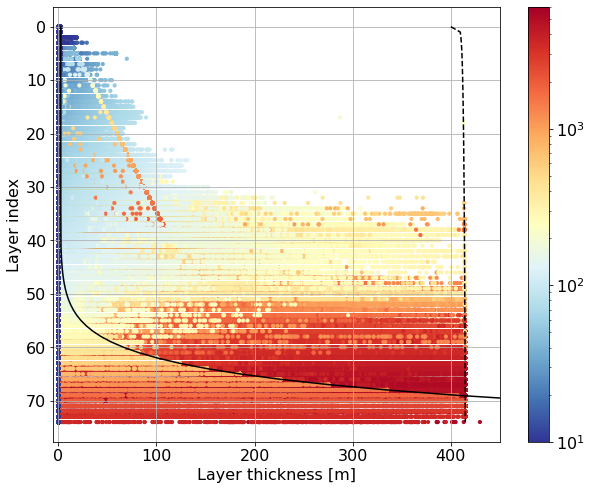

In [12]:
matplotlib.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(10,8))
for k in range(len(ics.Layer)):
    data = ics.h[0,k,:].values.flatten()
    if k == 0:
      z = 0.5 * ics.h[0,k,:].values
    else:
      z = ics.h[0,0:k-1,:].sum(dim=['Layer'], skipna=False).values + \
          0.5 * ics.h[0,k,:].values
        
    sc = ax.scatter(data, np.ones(len(data))*(k),
                    c=z, s=10, 
                    norm=colors.LogNorm(vmin=10, vmax=6000.), cmap='RdYlBu_r')

ax.plot(dz.values, range(len(dz)), 'k-', label='dz')
ax.plot(max_h, range(len(dz)), 'k--', label='dz_max')
#ax.legend()
ax.invert_yaxis()
ax.set_xlim(-5,450)
plt.colorbar(sc)
plt.xlabel('Layer thickness [m]')
plt.ylabel('Layer index')
plt.grid()

### Maximum thicknesses based on the values above the 90% quantile

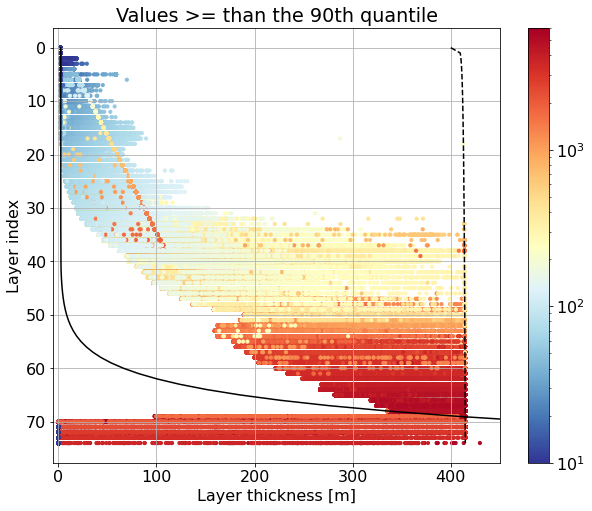

In [13]:
fig, ax = plt.subplots(figsize=(10,8))
for k in range(len(ics.Layer)):
    data = get_quantile(ics.h[0,k,:], quantile=0.9, dims=['lath','lonh'])
    data = data.values.flatten()
    if k == 0:
      z = 0.5 * ics.h[0,k,:].values
    else:
      z = ics.h[0,0:k-1,:].sum(dim=['Layer'], skipna=False).values + \
          0.5 * ics.h[0,k,:].values
        
    sc = ax.scatter(data, np.ones(len(data))*(k),
                    c=z, s=10, 
                    norm=colors.LogNorm(vmin=10, vmax=6000.), cmap='RdYlBu_r')

ax.plot(dz.values, range(len(dz)), 'k-', label='dz')
ax.plot(max_h, range(len(dz)), 'k--', label='dz_max')
#ax.legend()
ax.invert_yaxis()
ax.set_xlim(-5,450)
plt.colorbar(sc)
plt.xlabel('Layer thickness [m]')
plt.ylabel('Layer index')
plt.title('Values >= than the 90th quantile')
plt.grid()

#### Maps

/glade/derecho/scratch/gmarques/tmp/ipykernel_2588/956470891.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24,6.5))


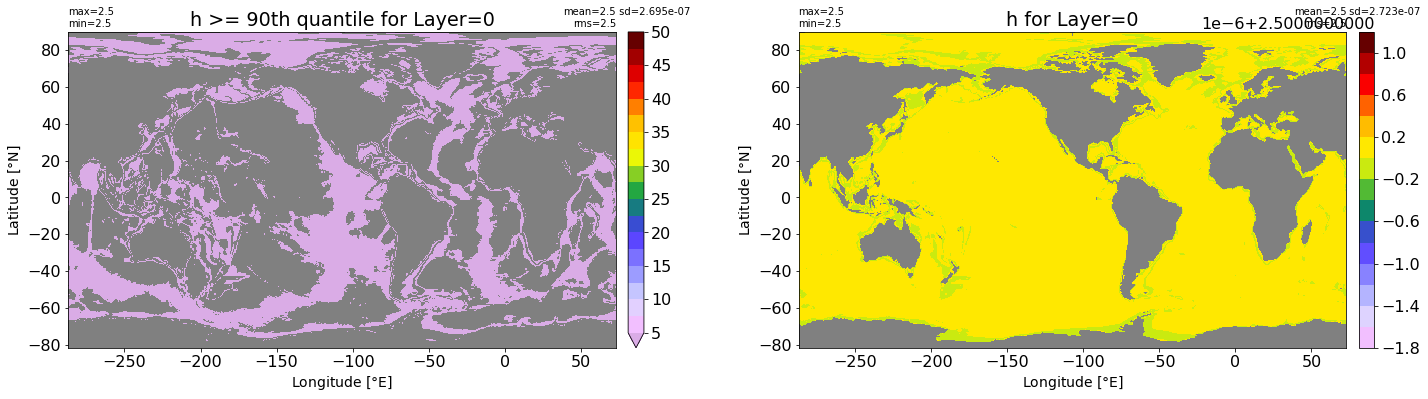

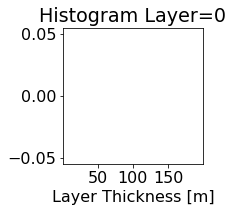

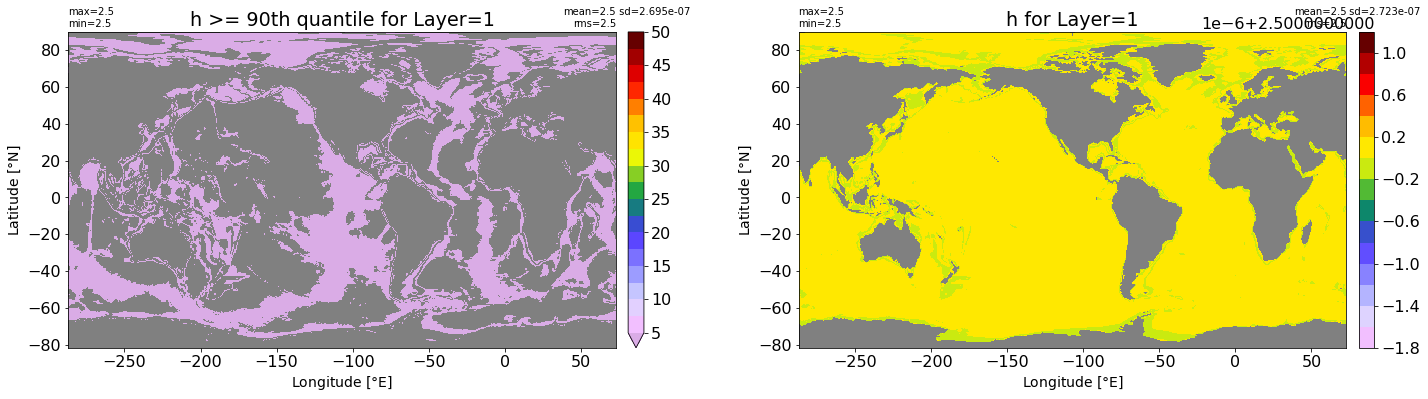

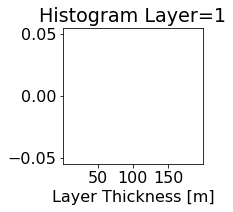

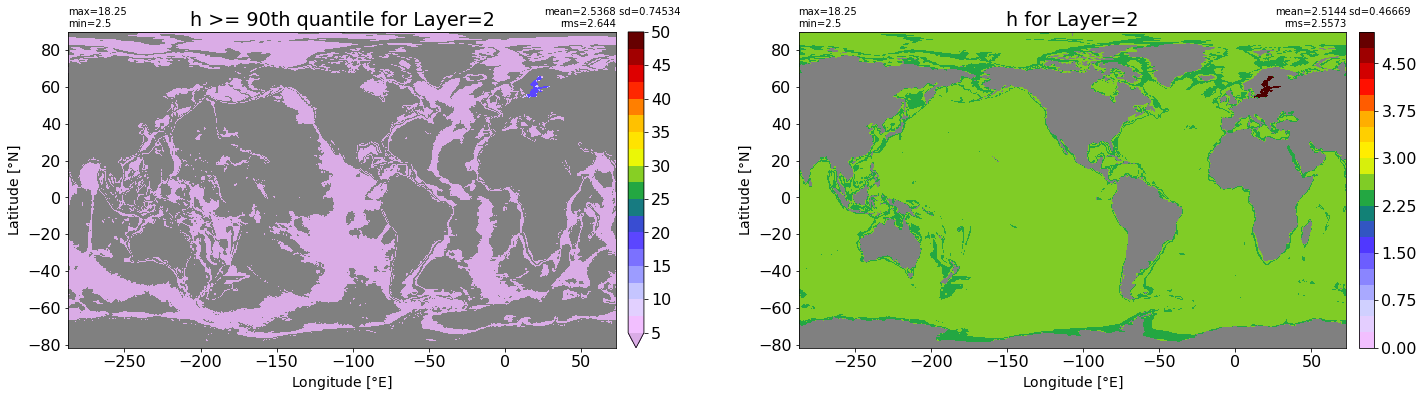

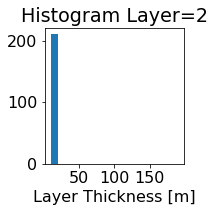

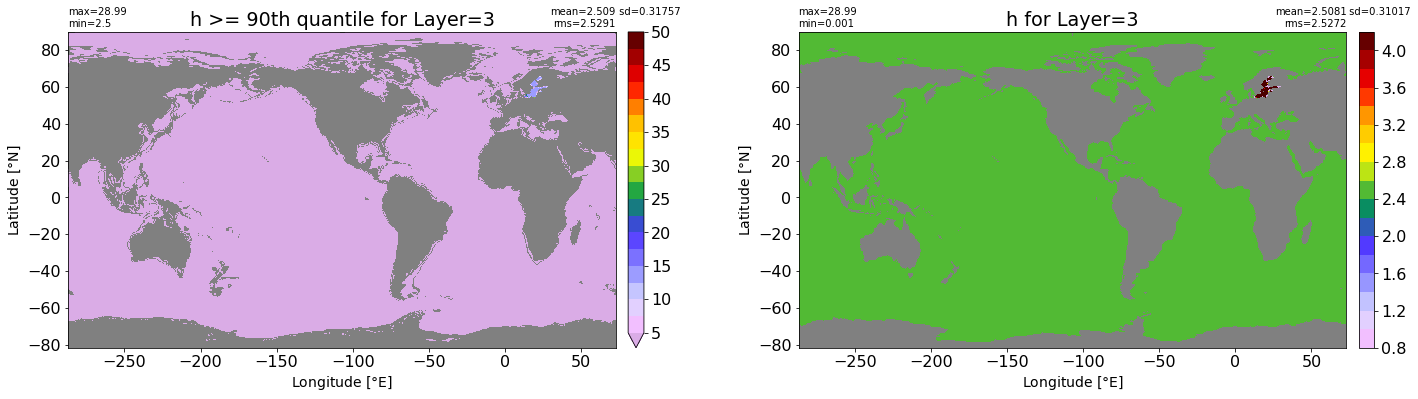

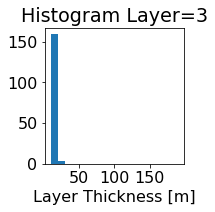

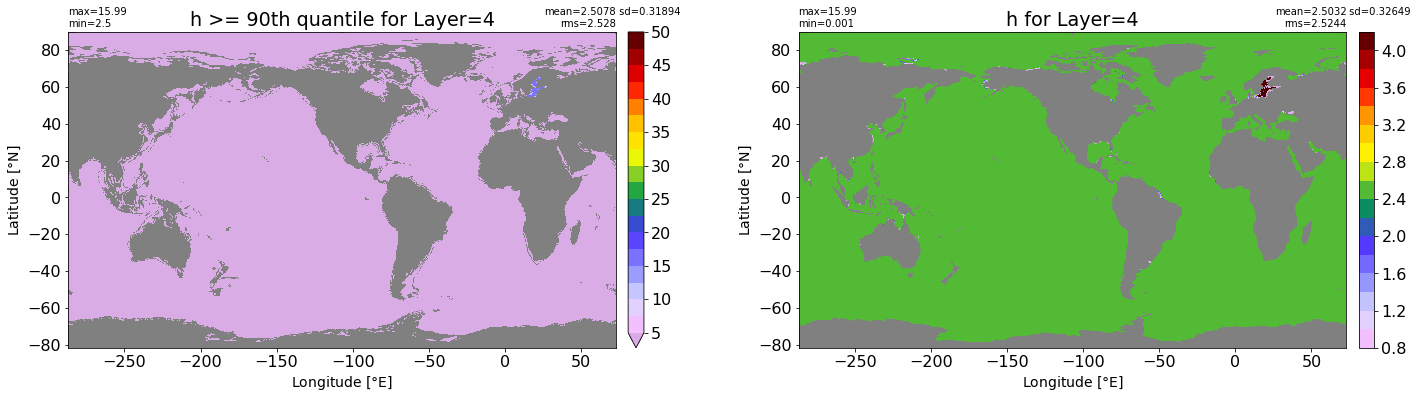

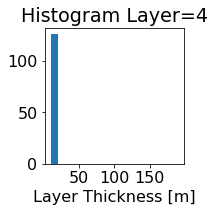

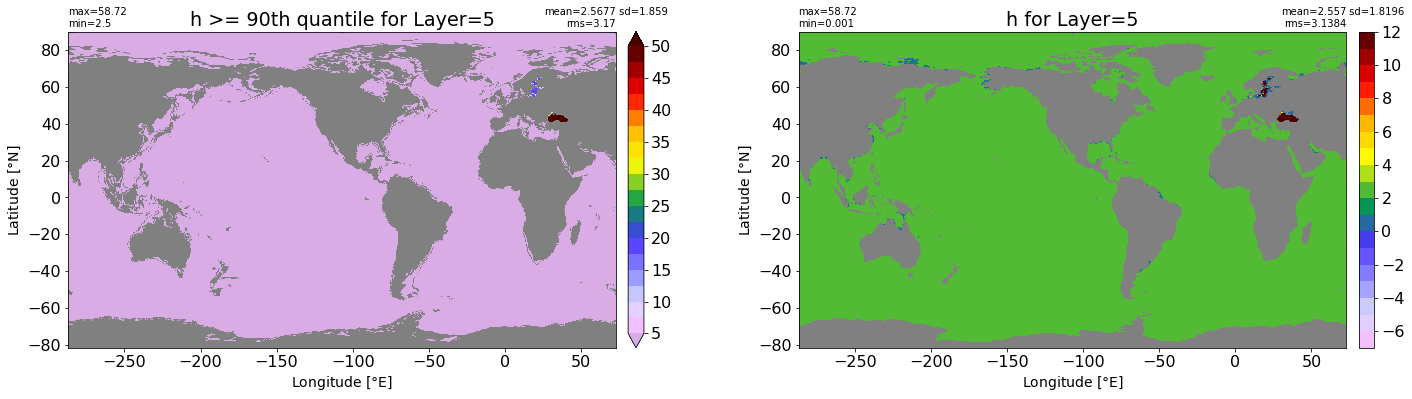

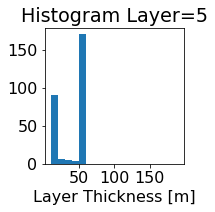

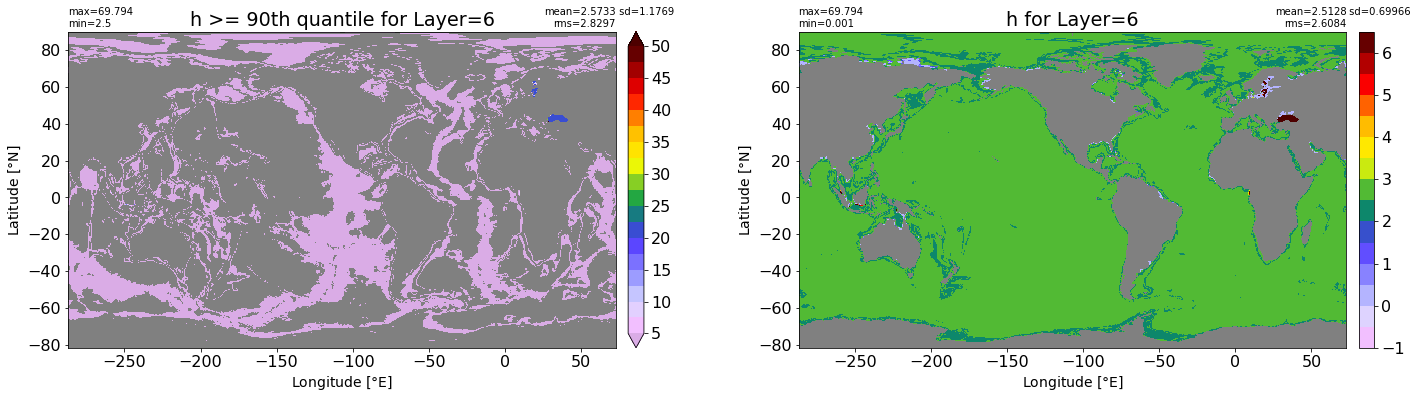

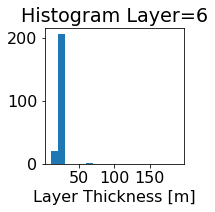

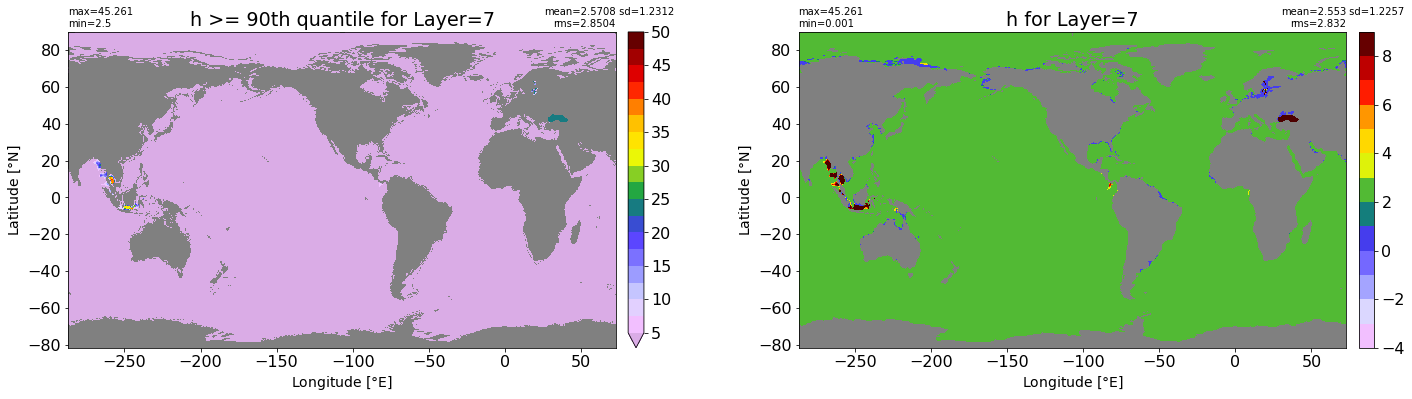

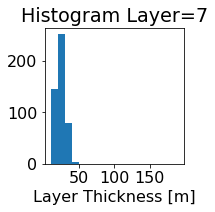

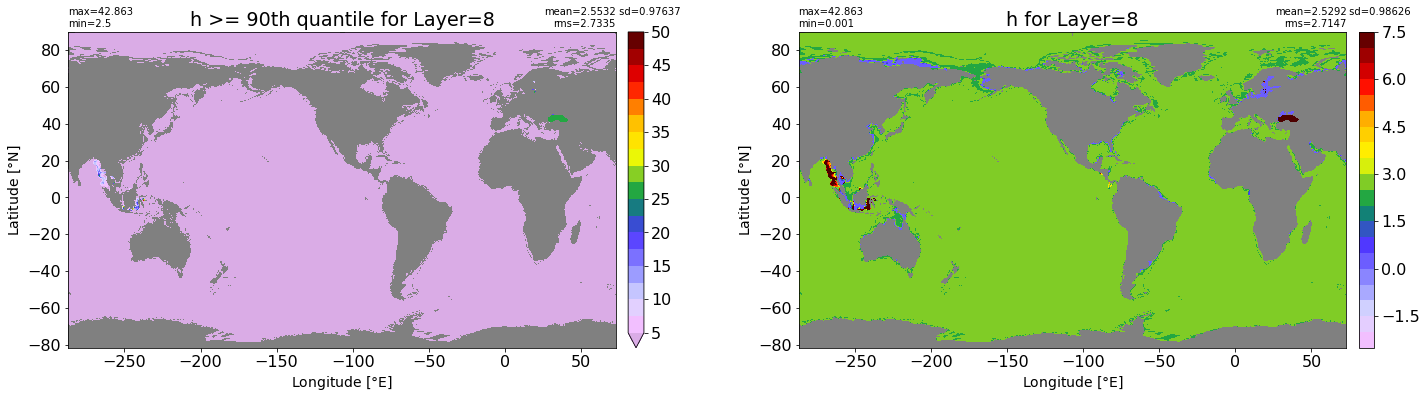

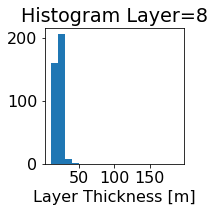

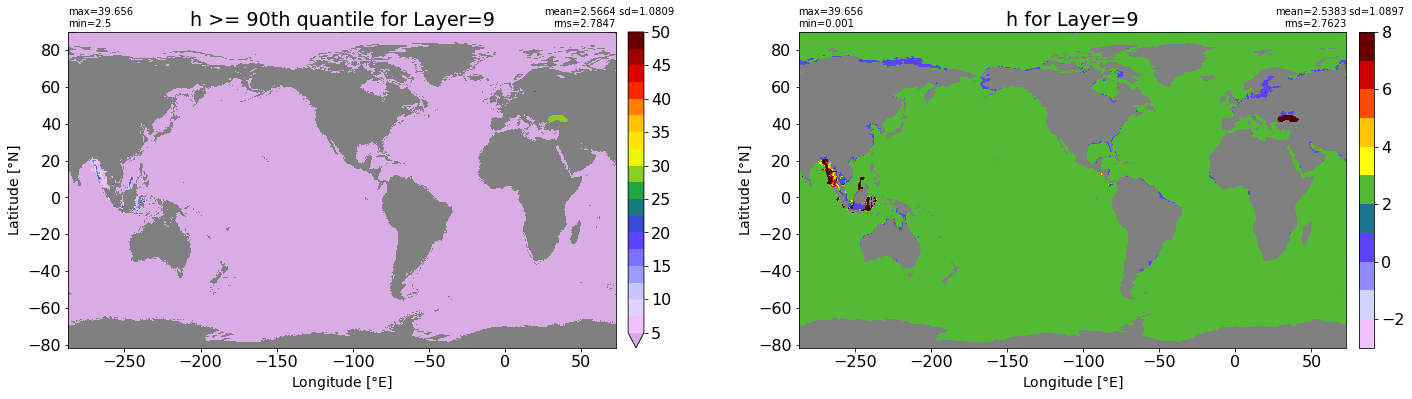

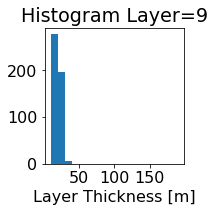

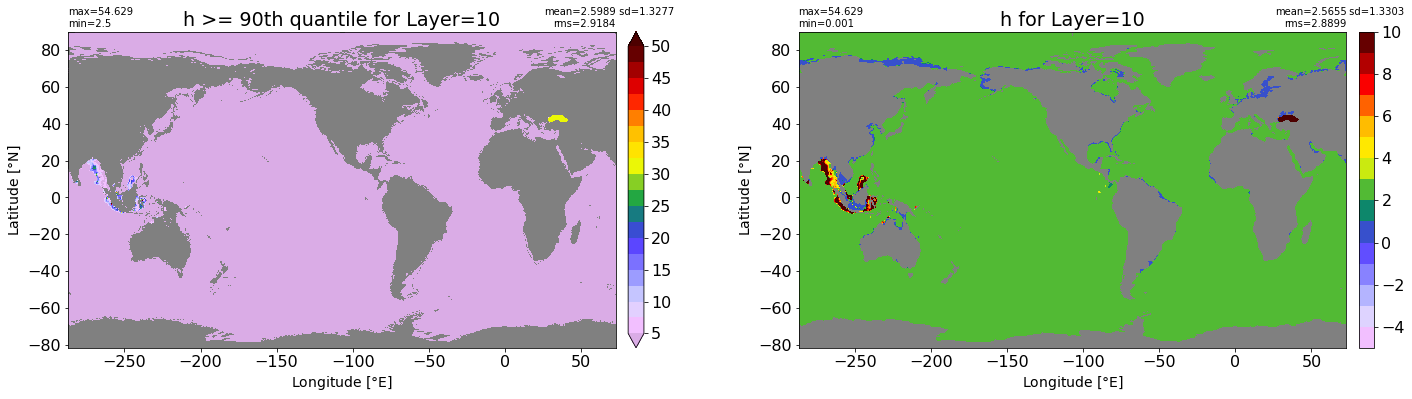

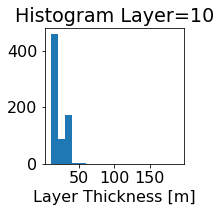

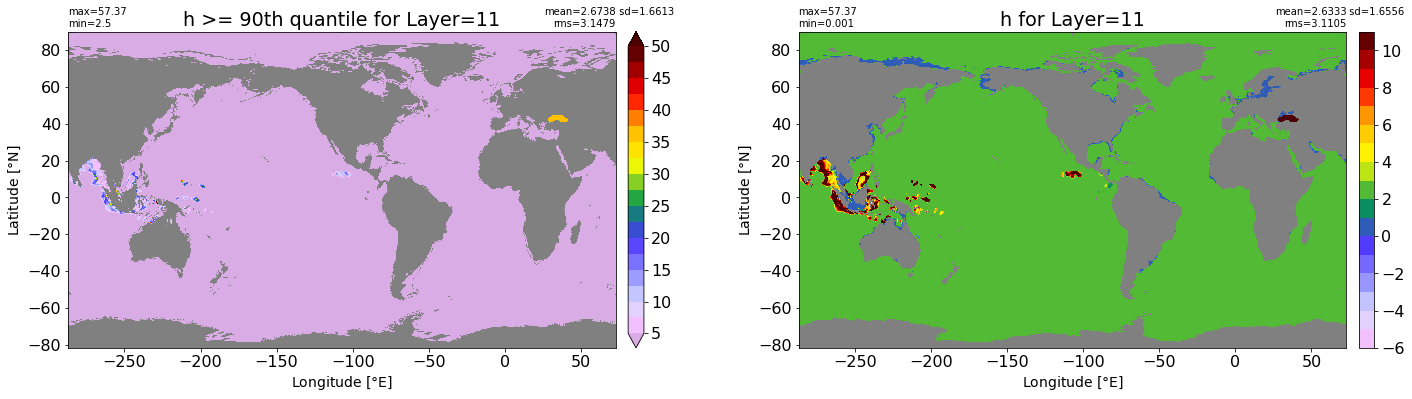

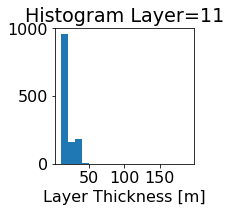

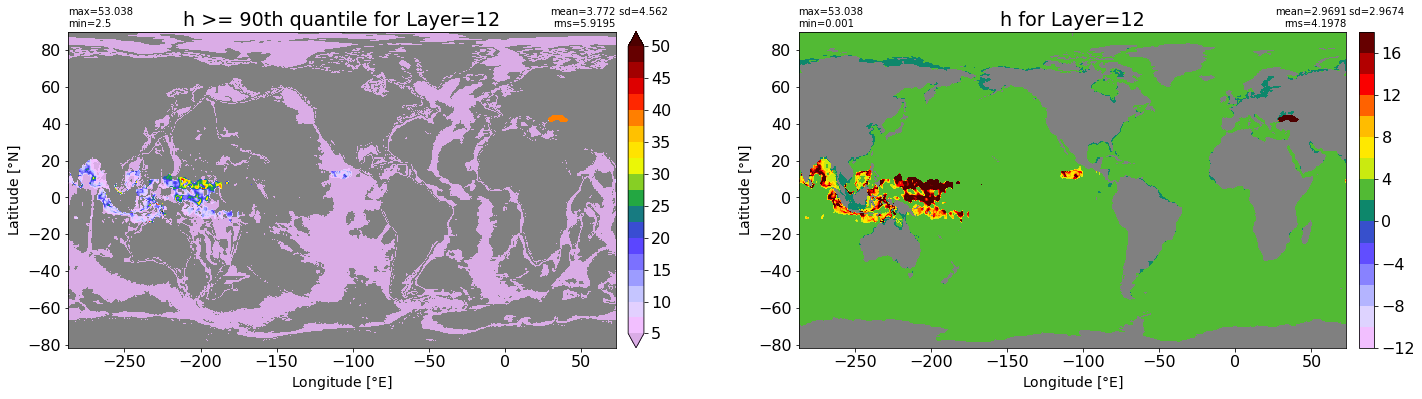

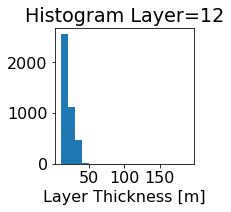

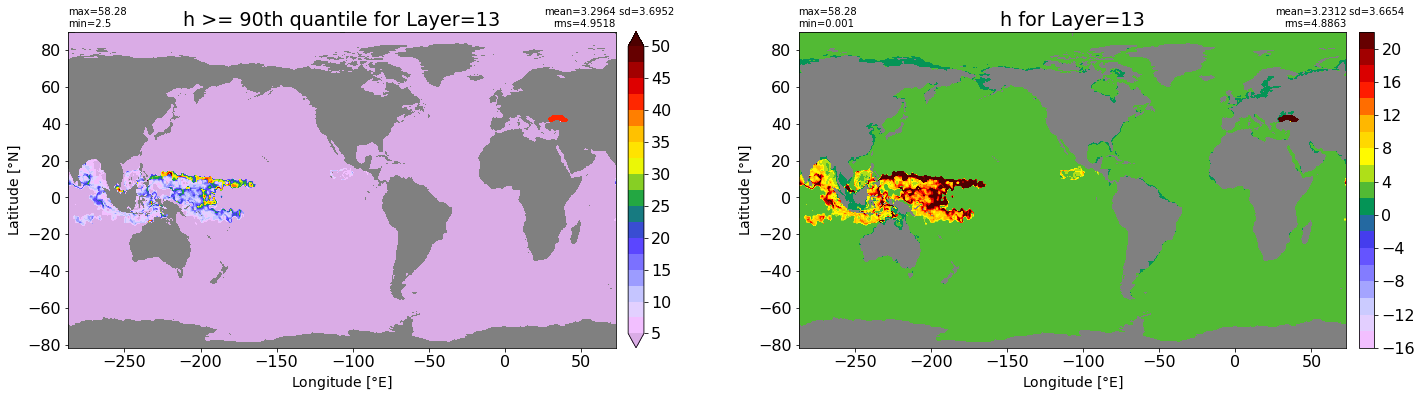

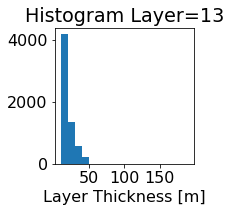

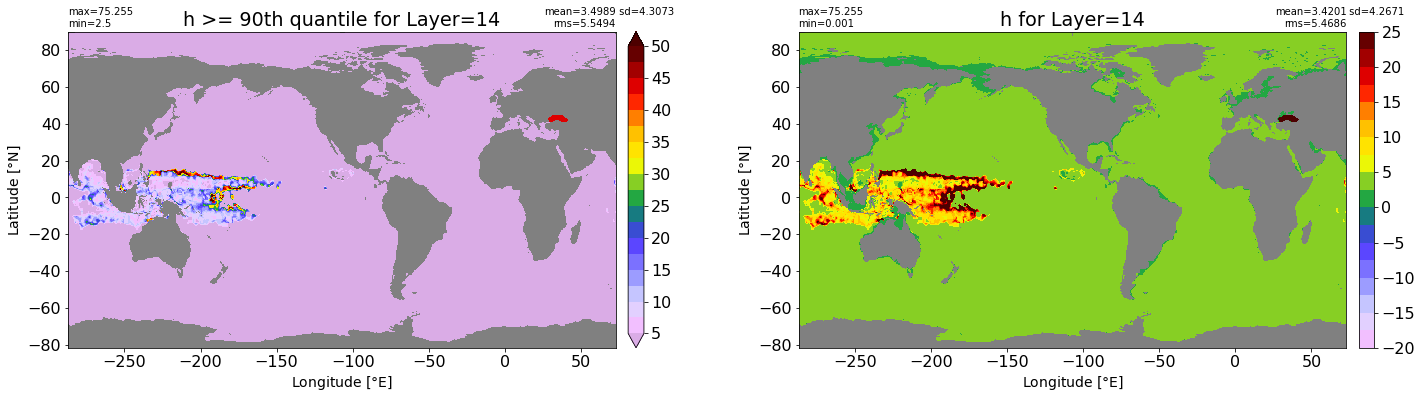

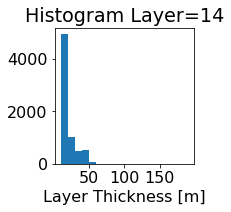

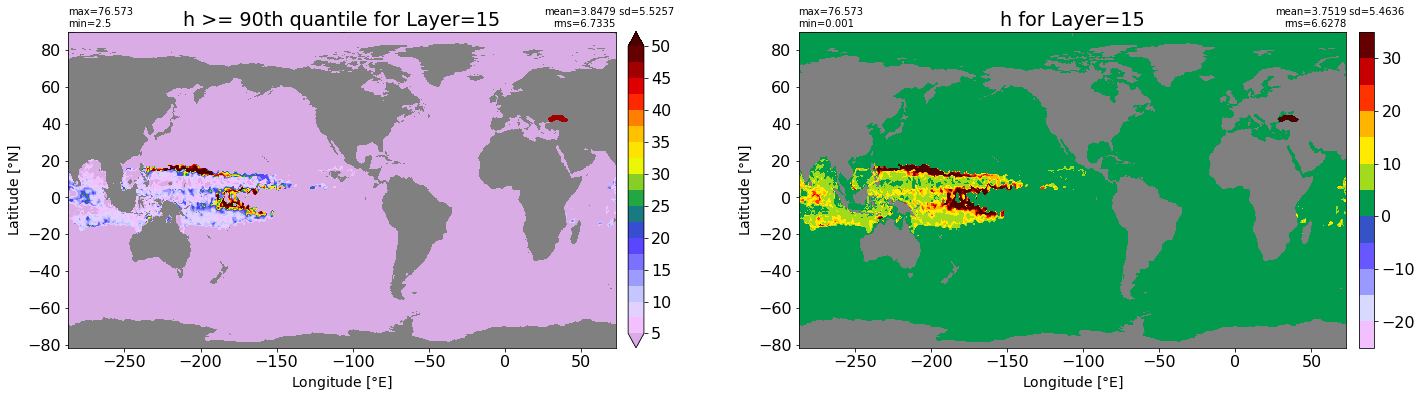

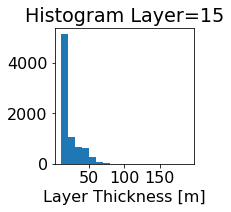

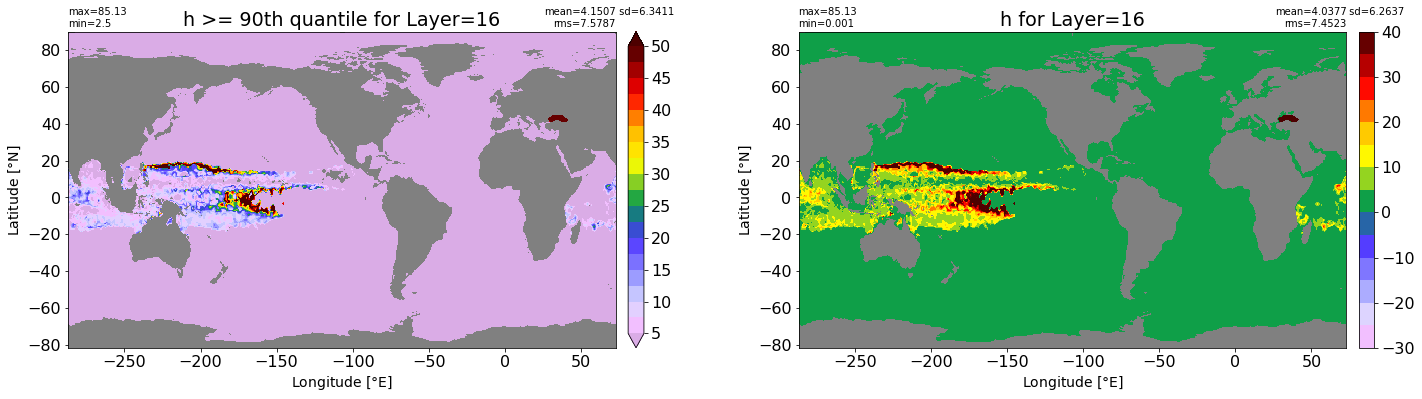

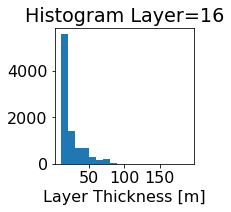

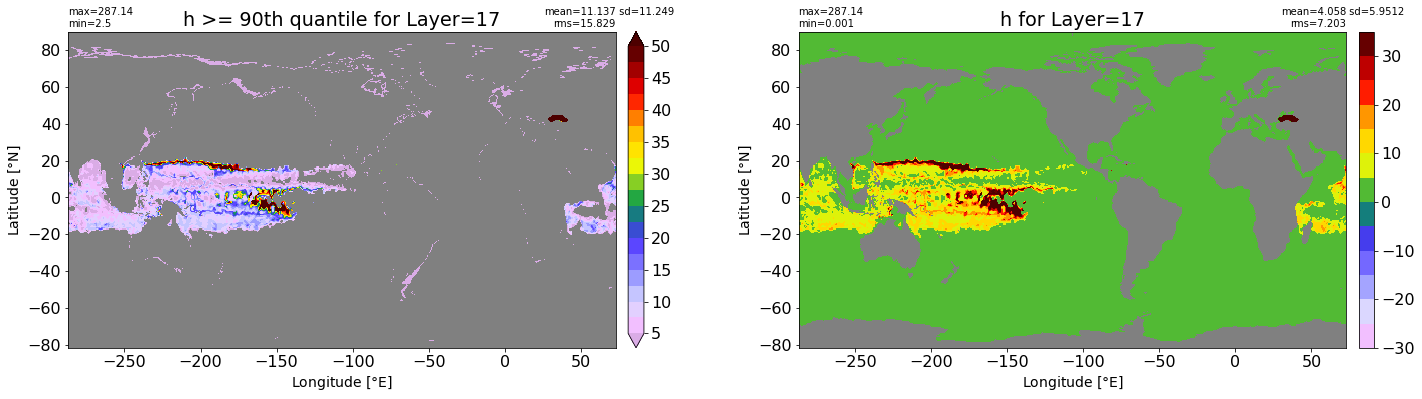

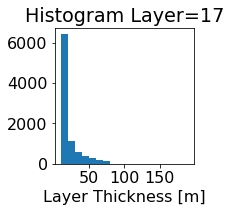

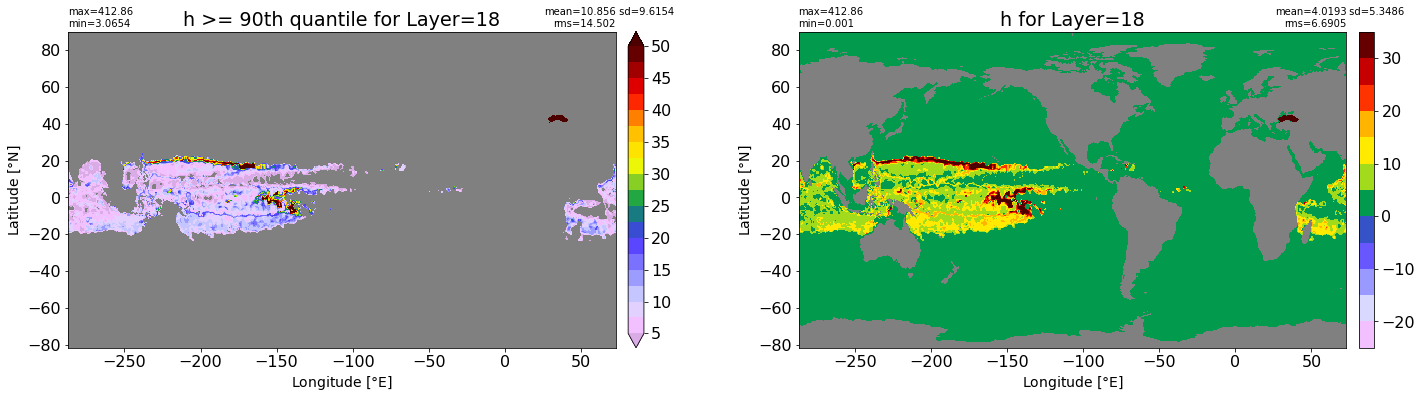

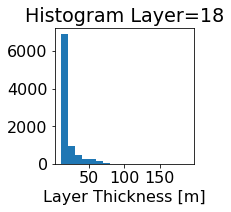

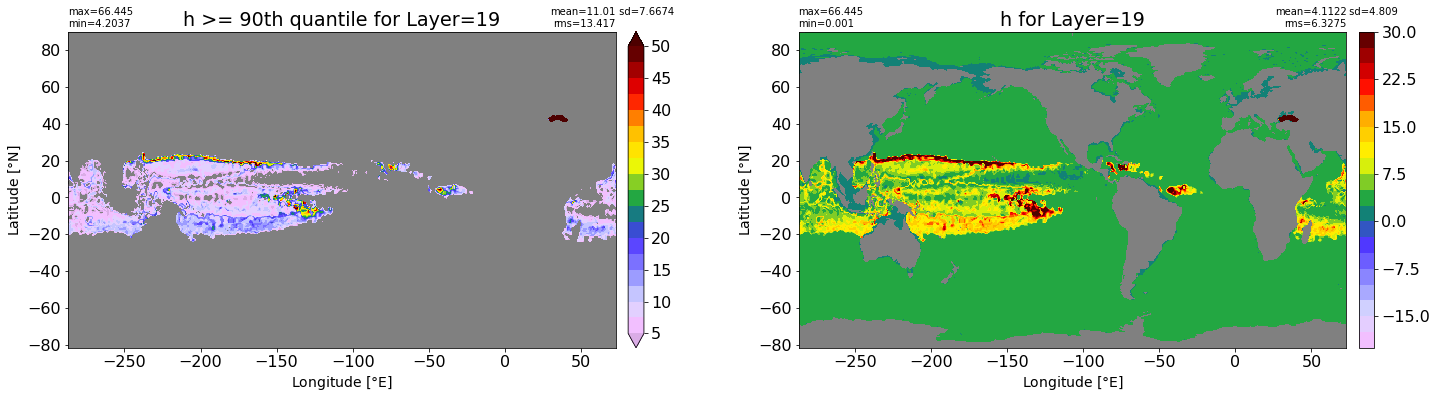

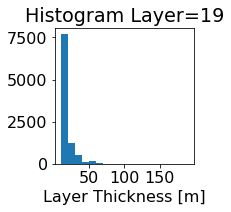

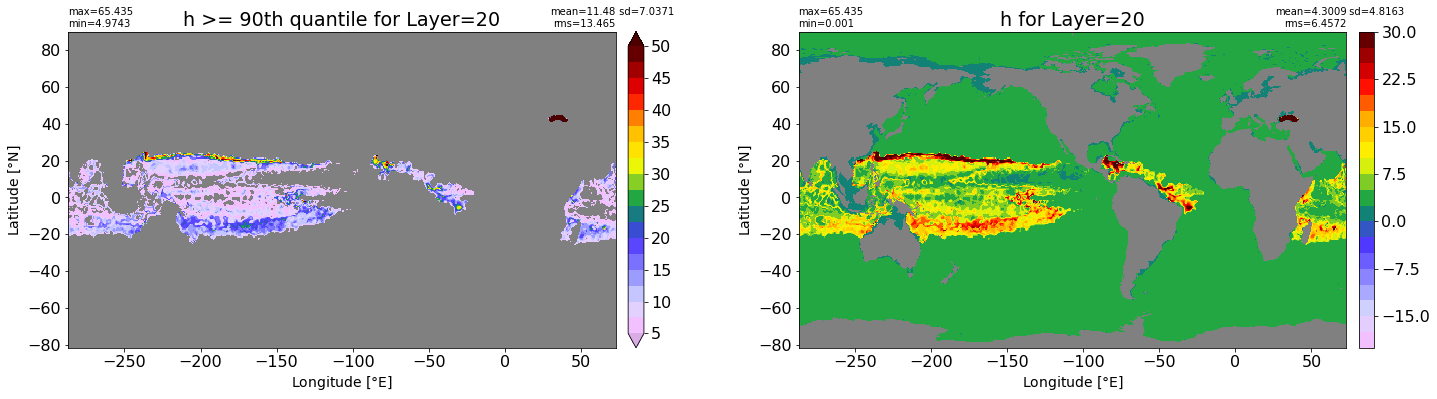

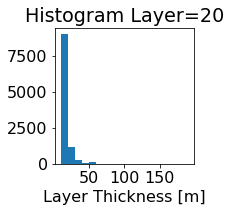

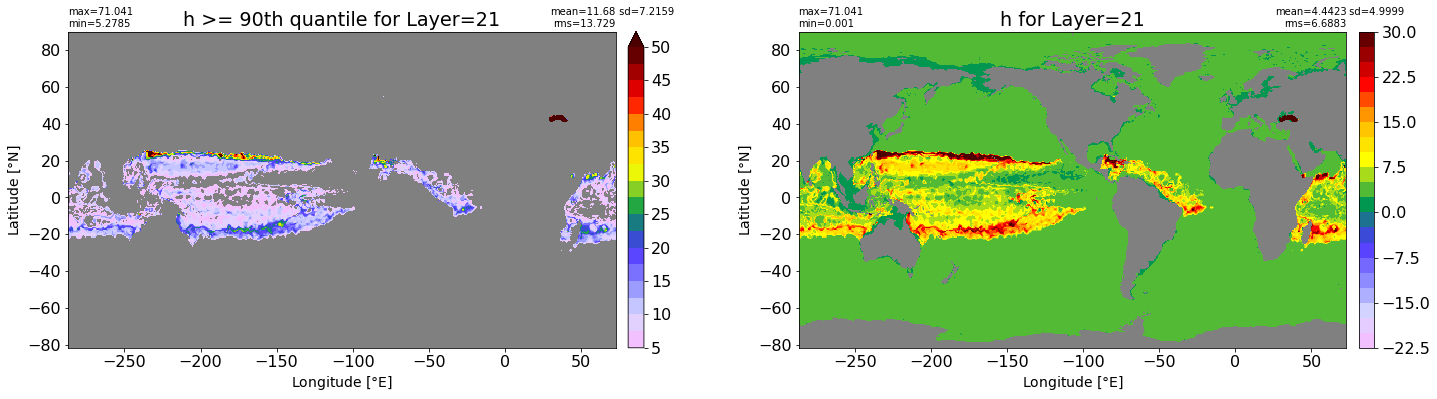

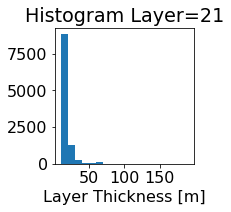

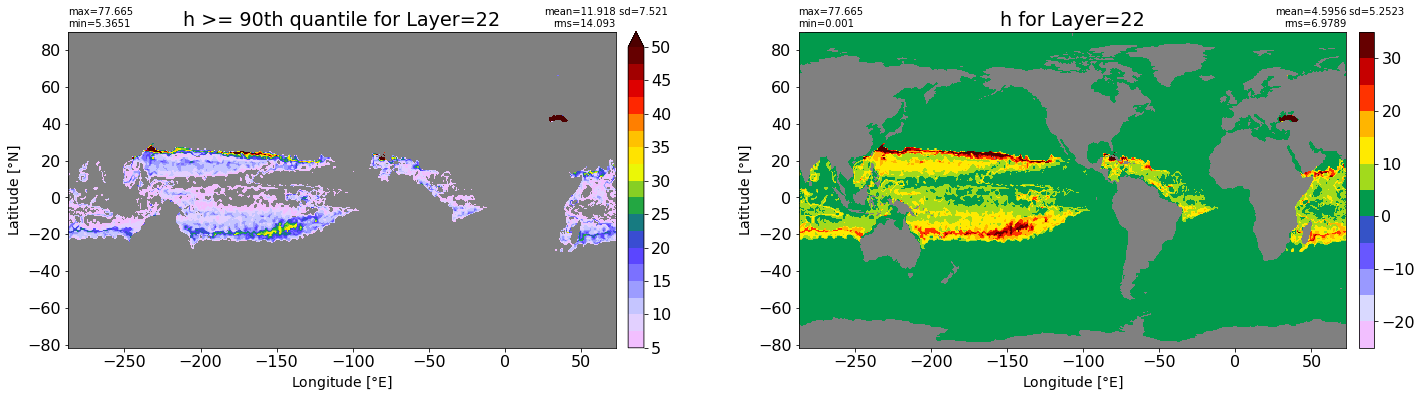

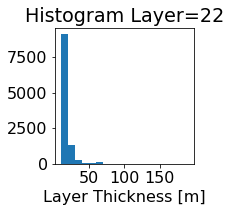

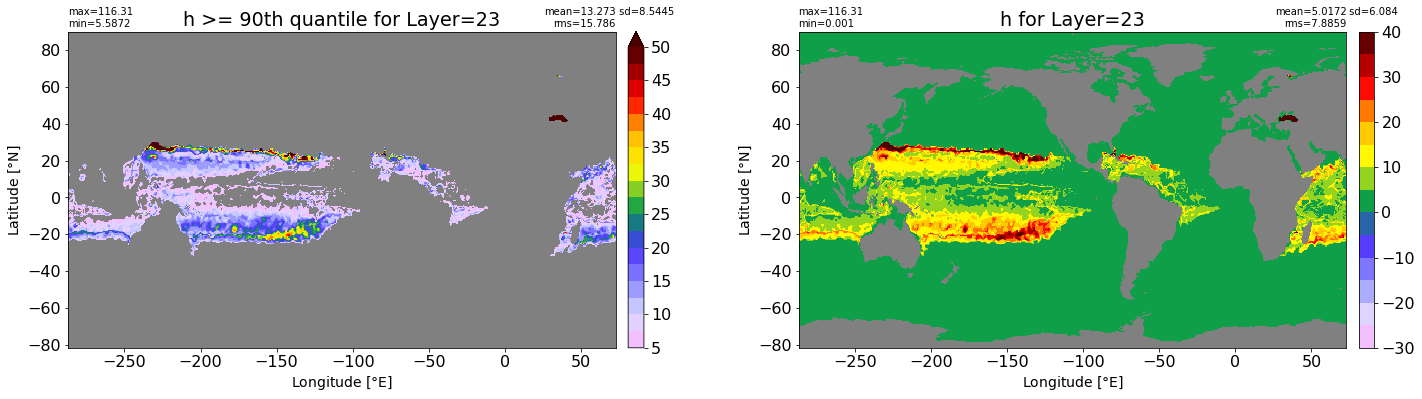

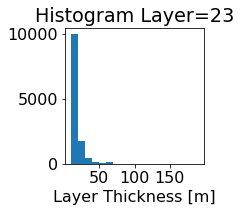

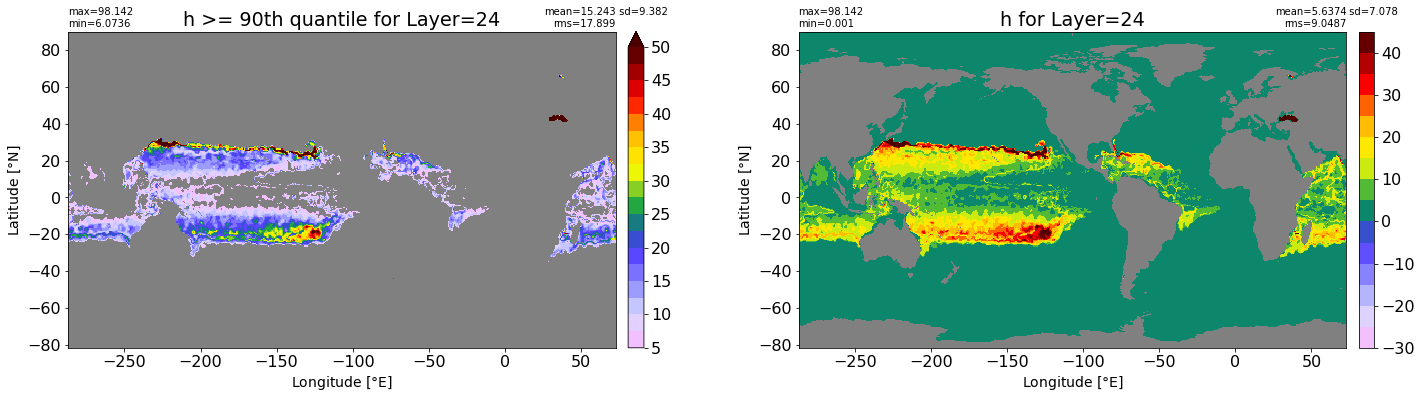

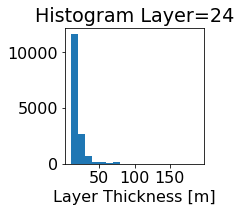

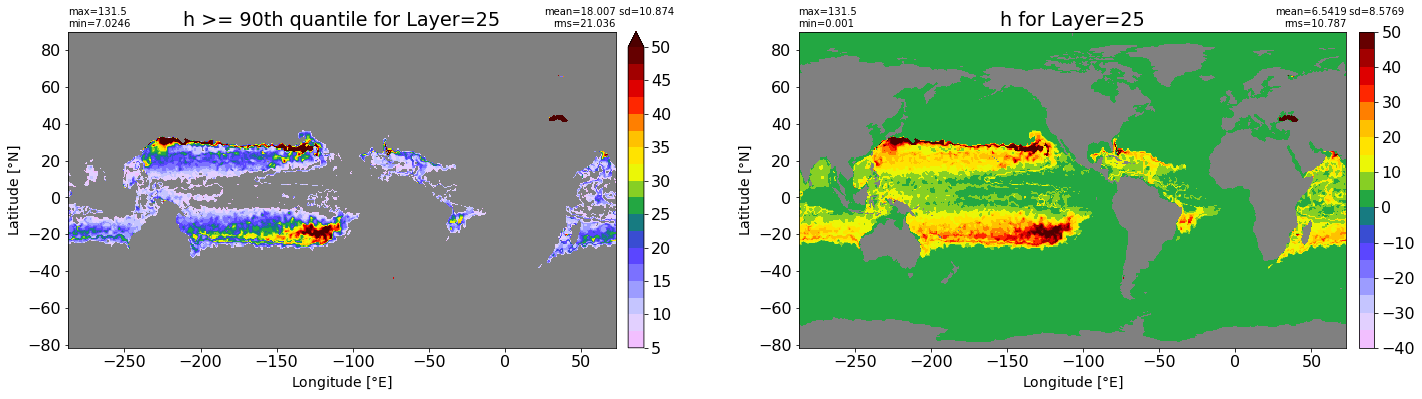

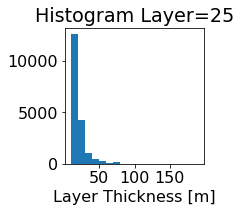

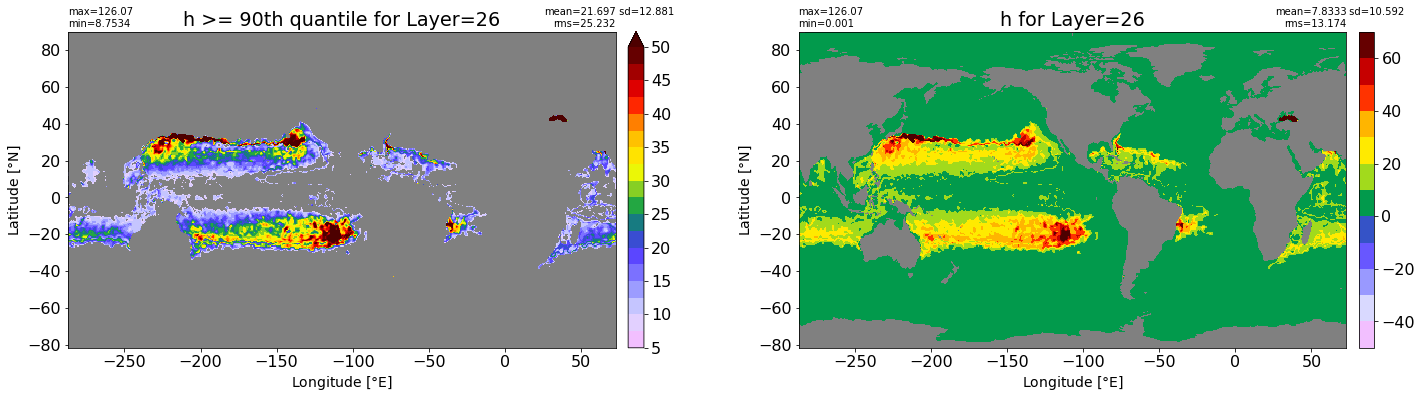

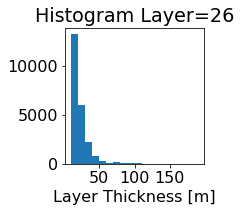

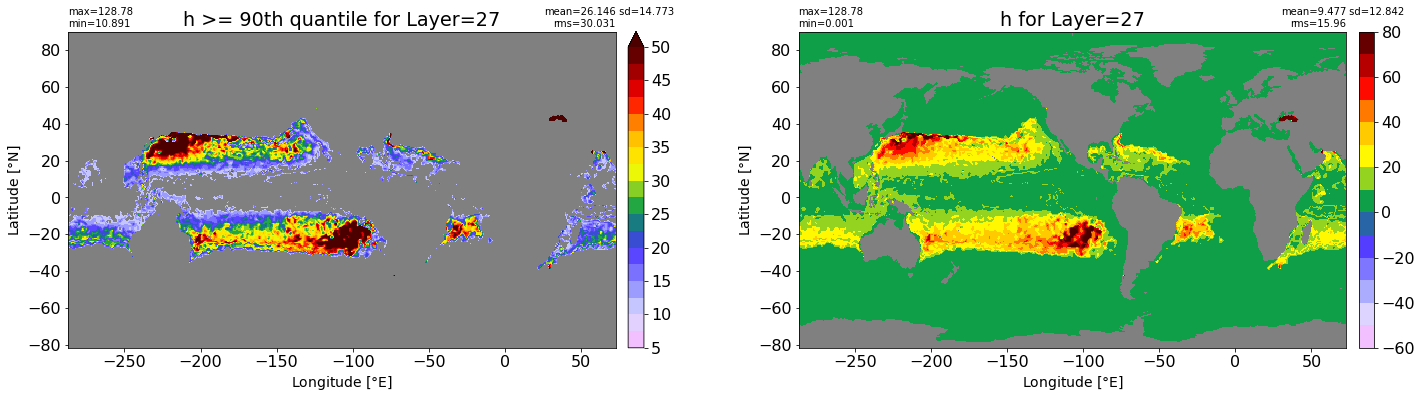

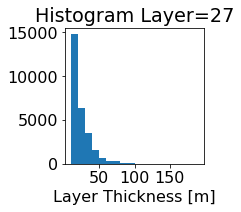

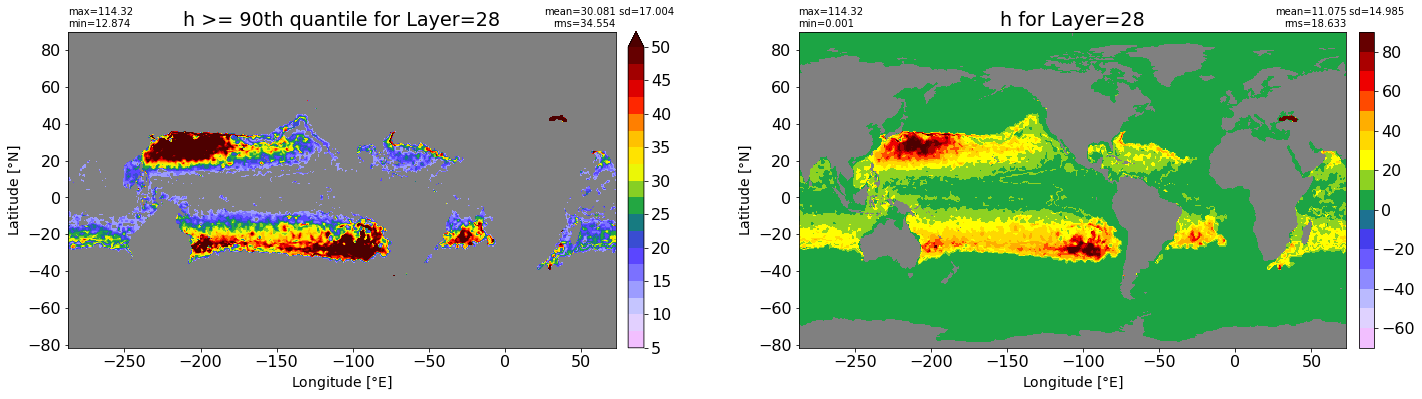

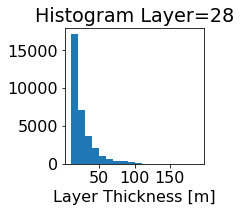

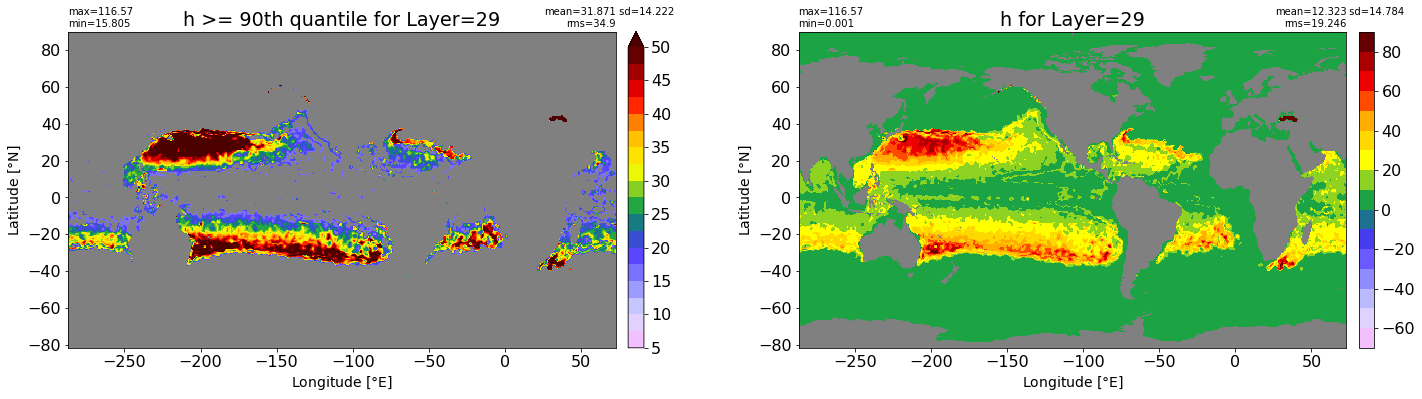

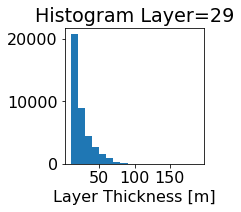

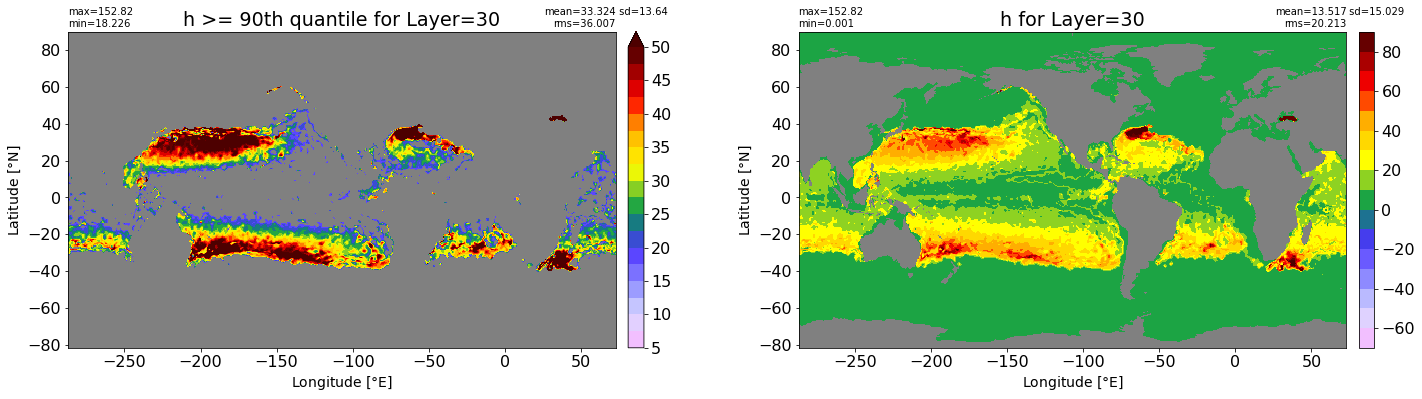

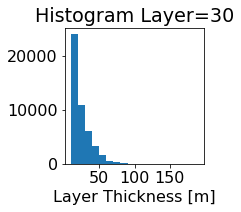

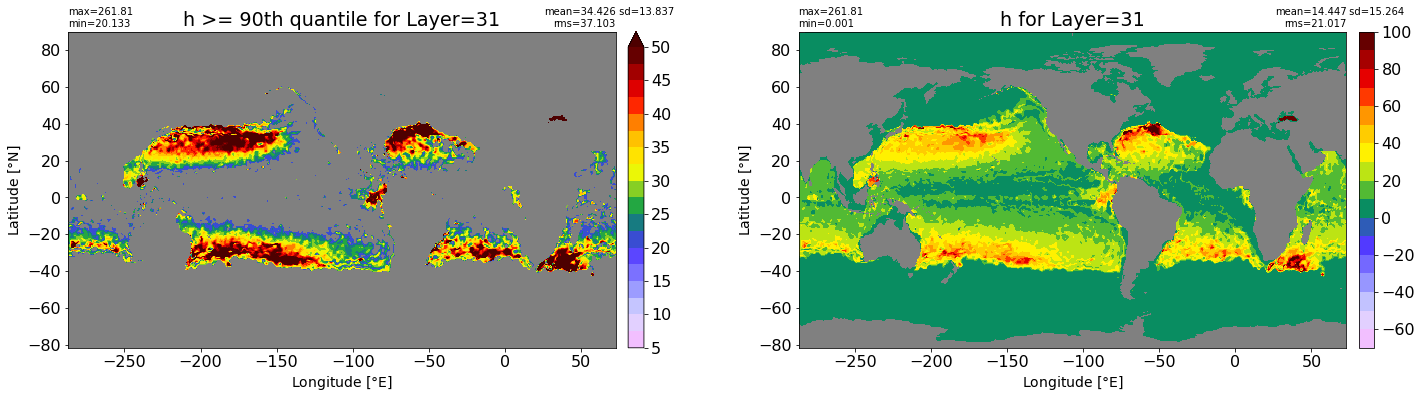

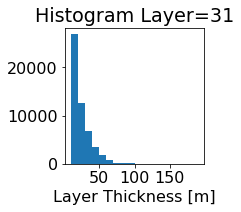

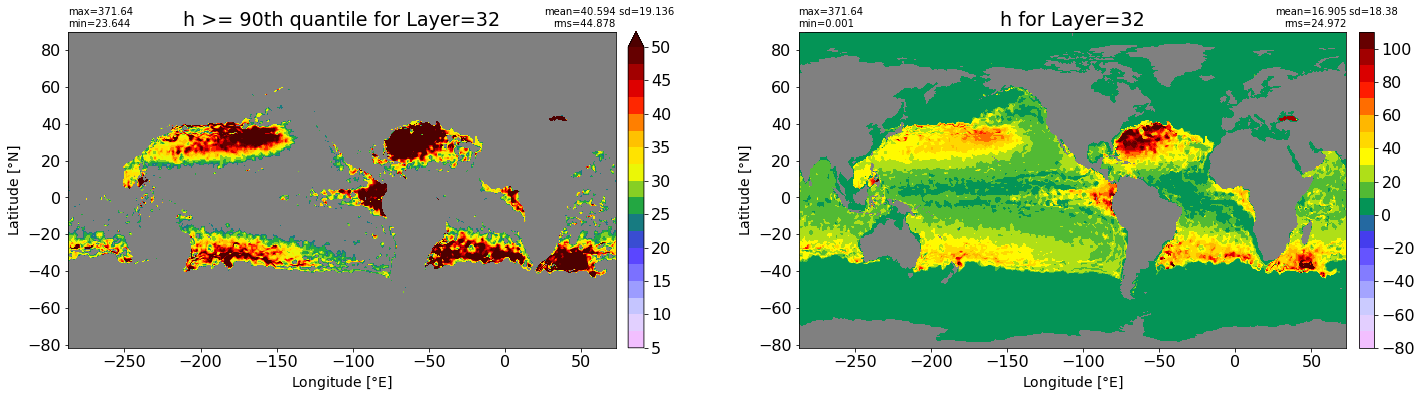

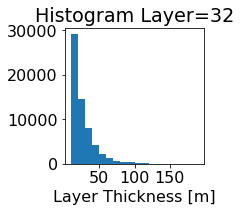

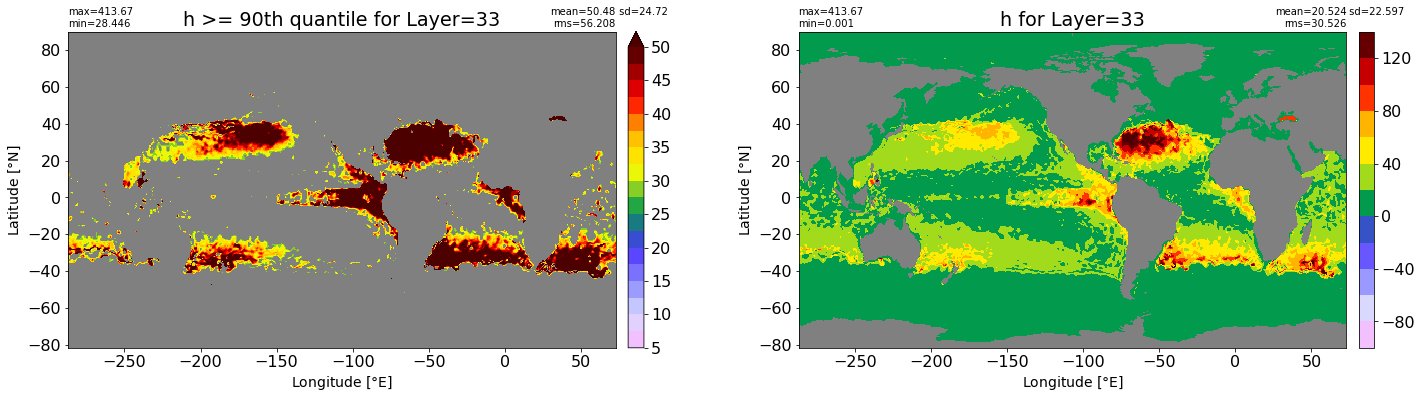

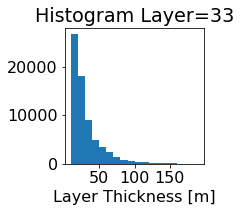

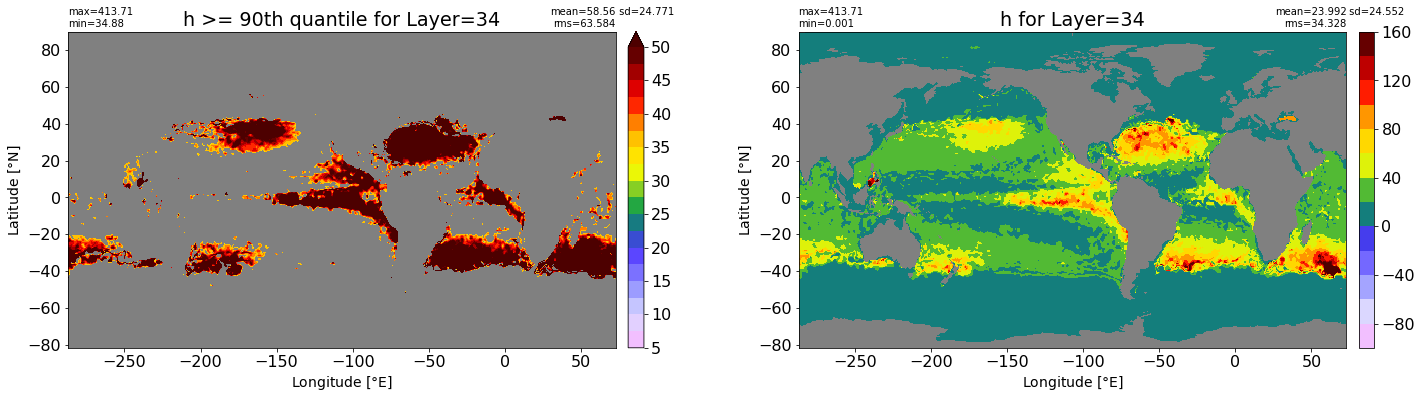

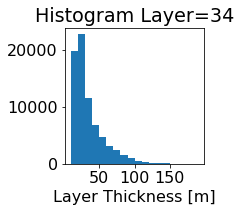

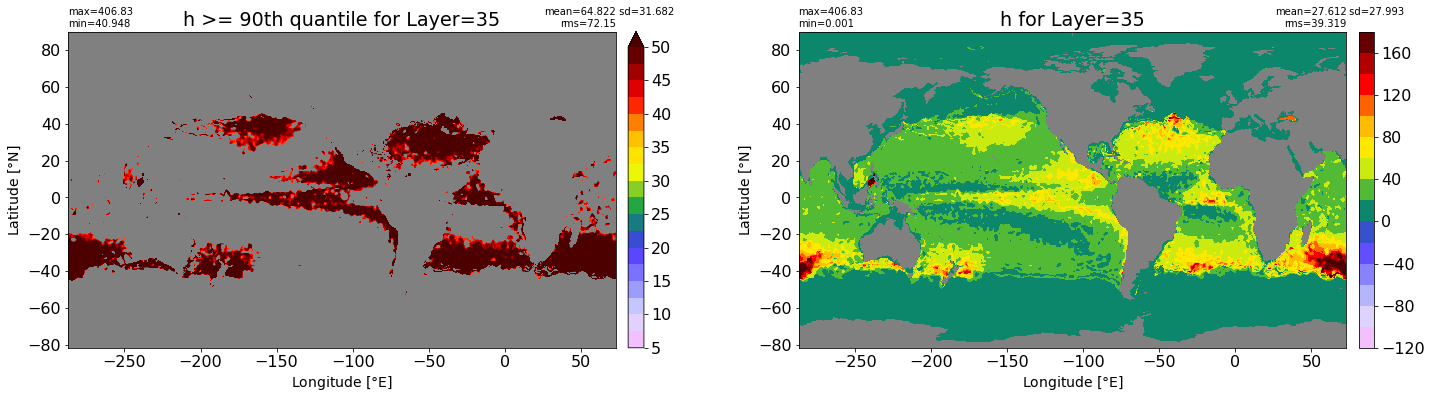

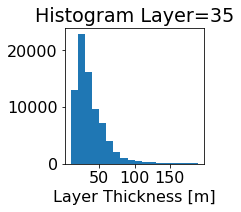

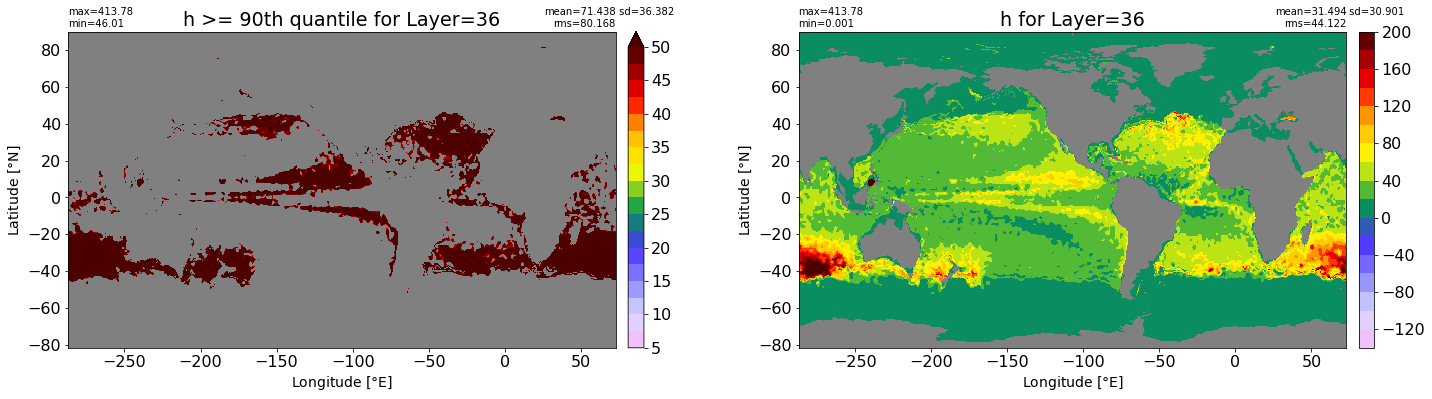

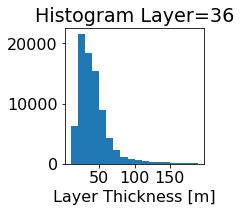

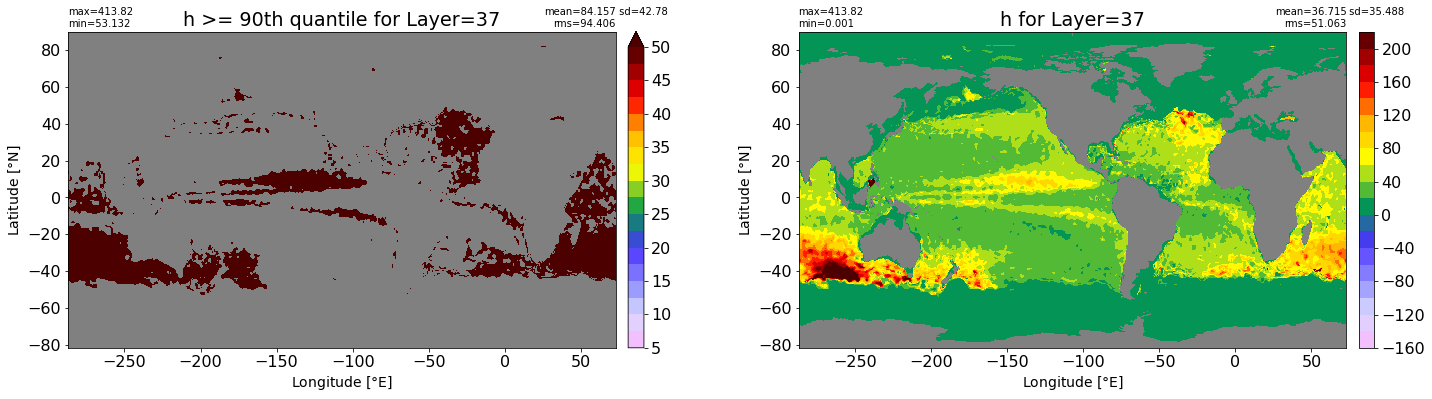

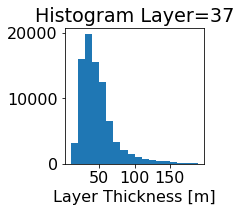

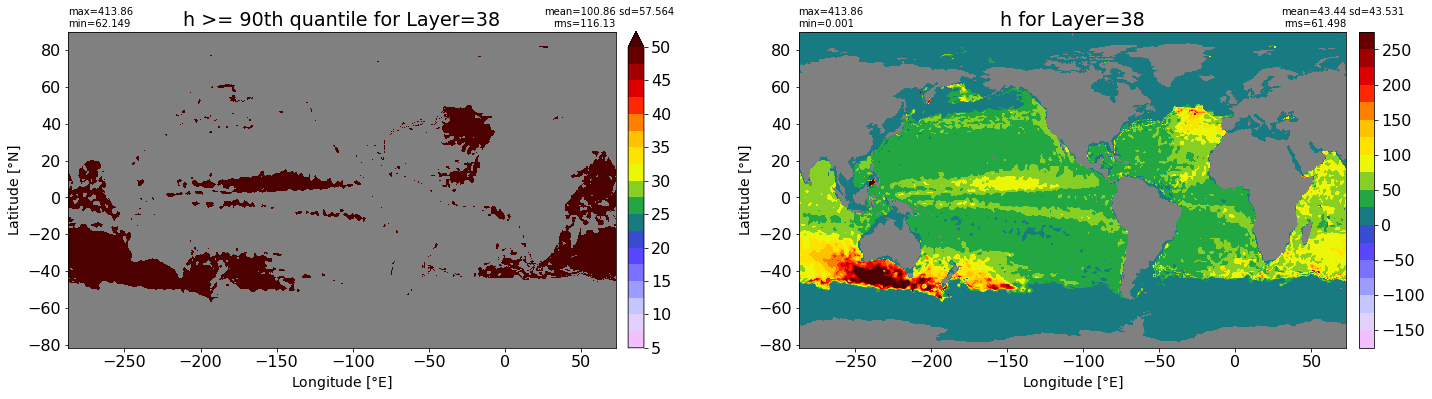

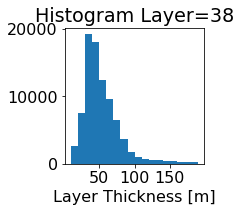

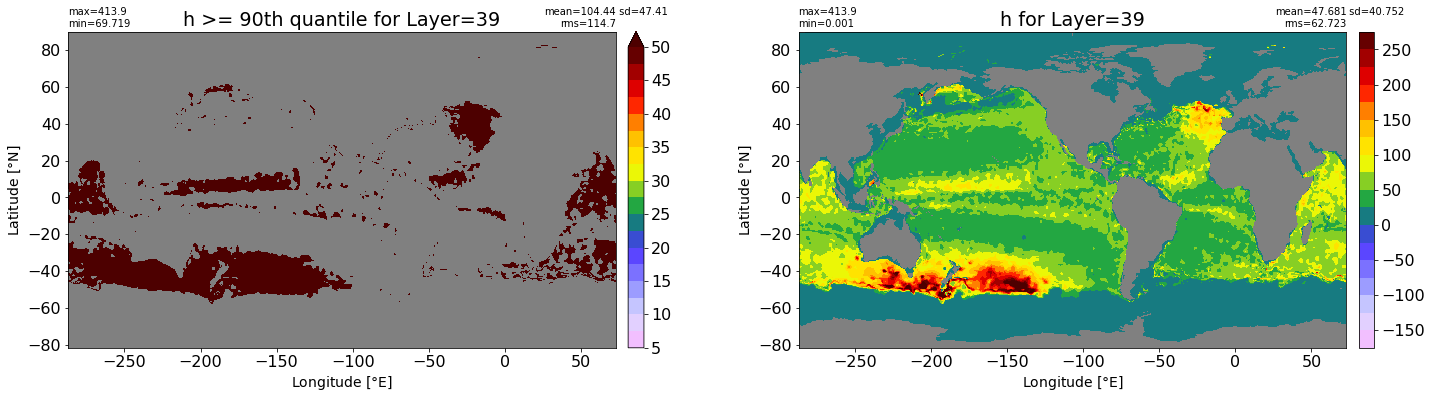

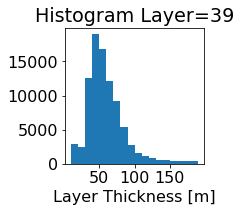

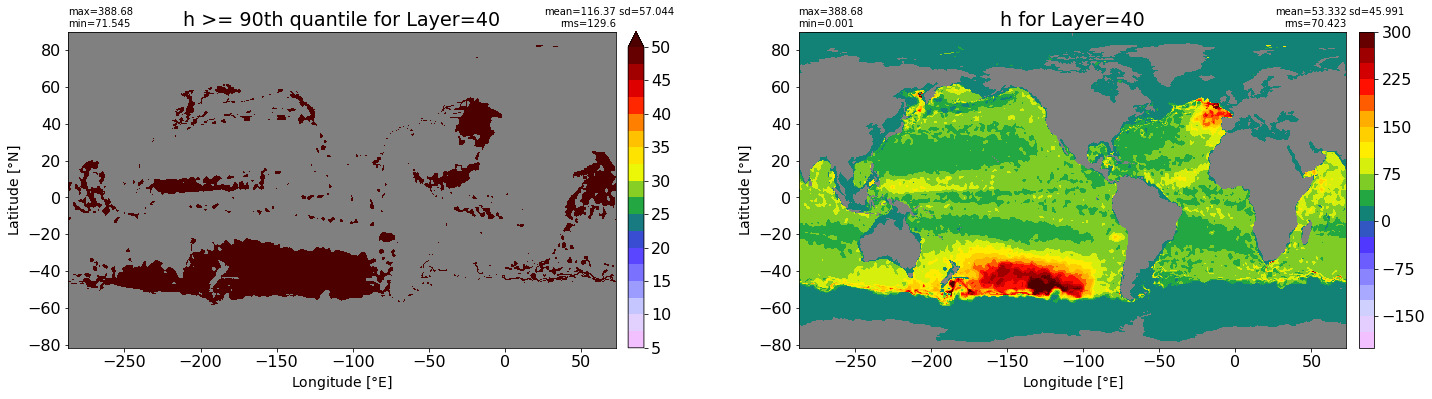

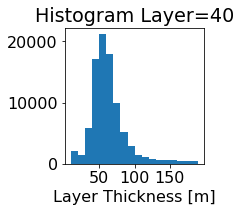

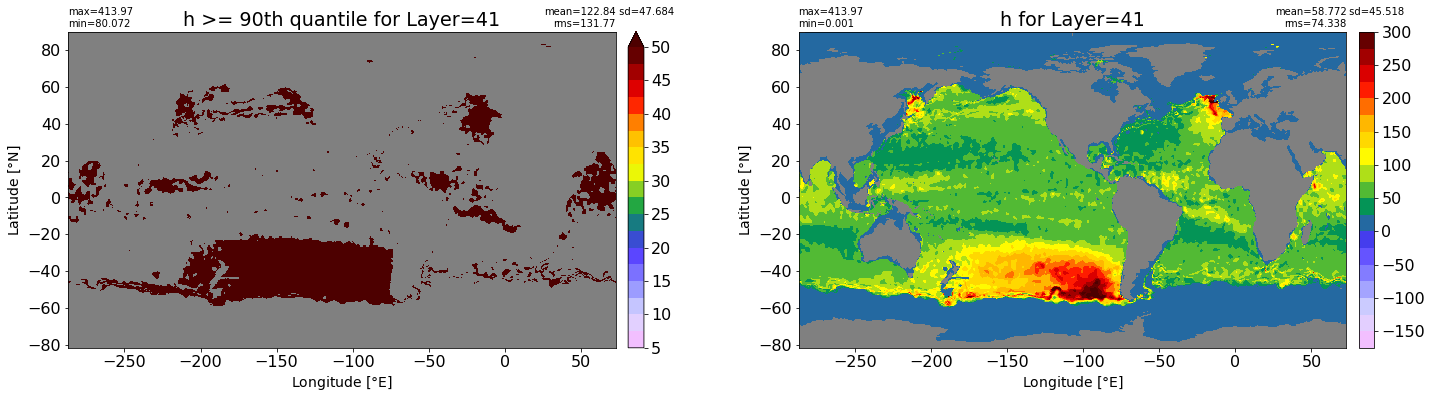

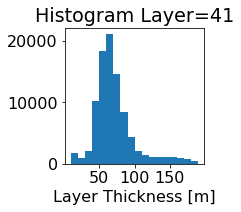

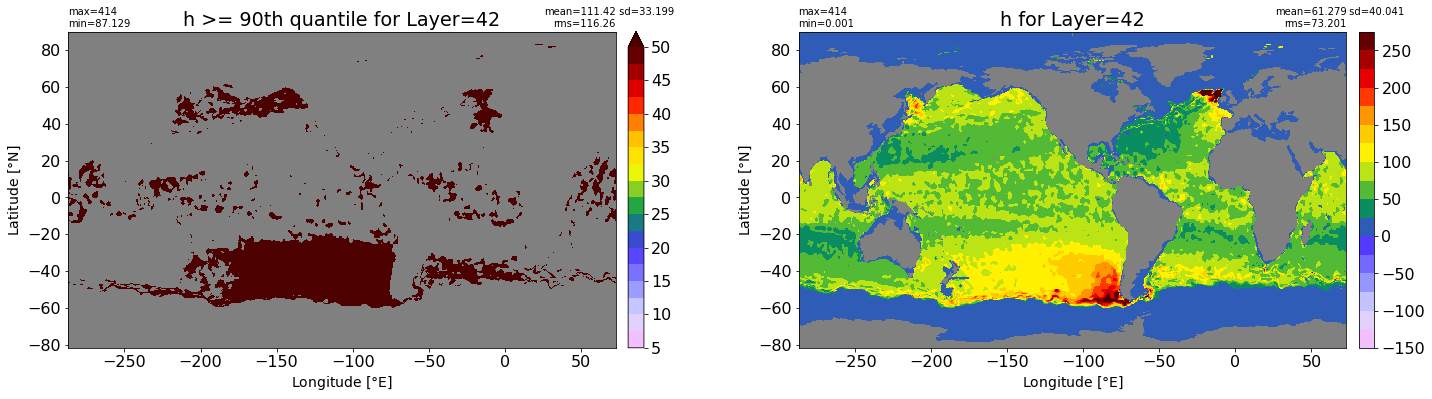

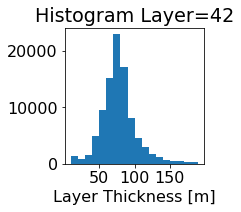

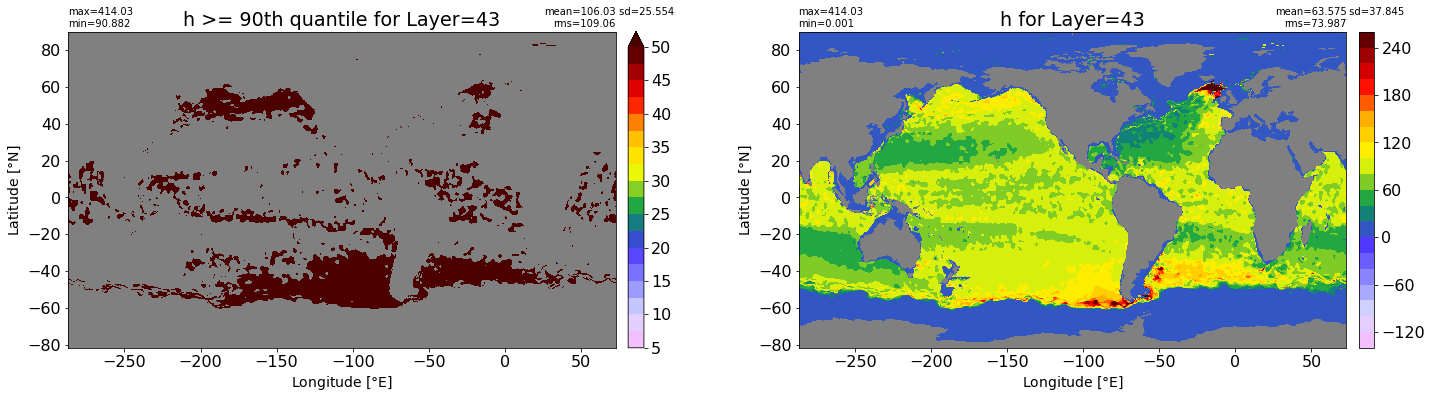

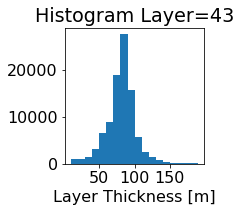

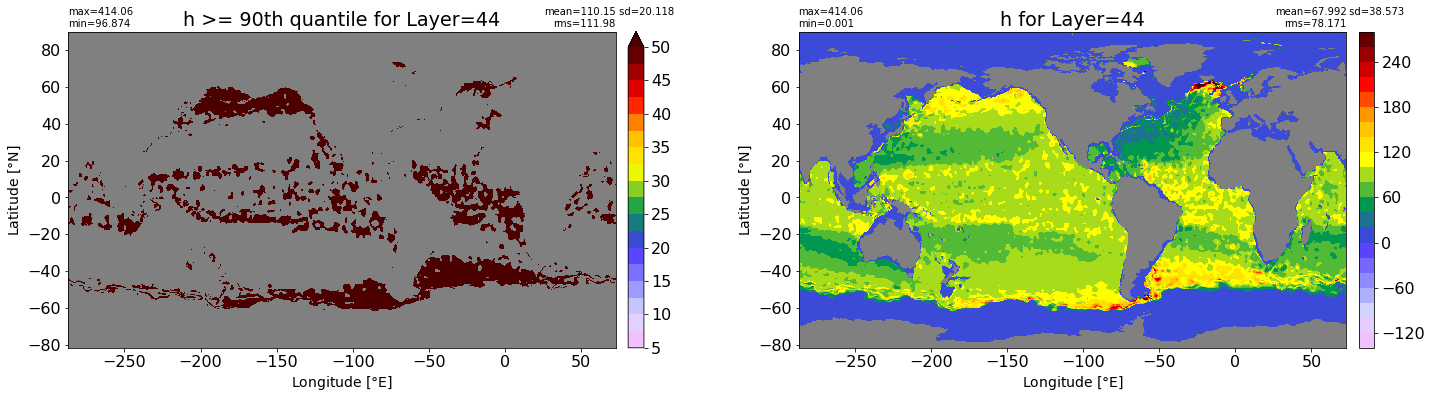

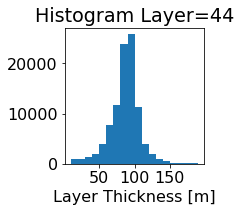

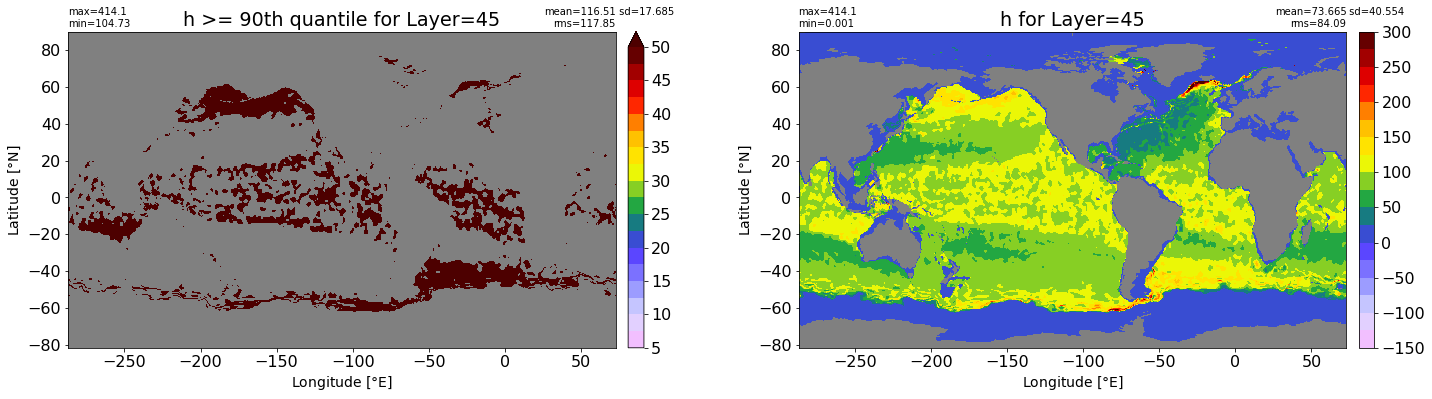

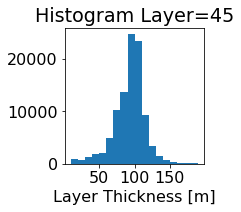

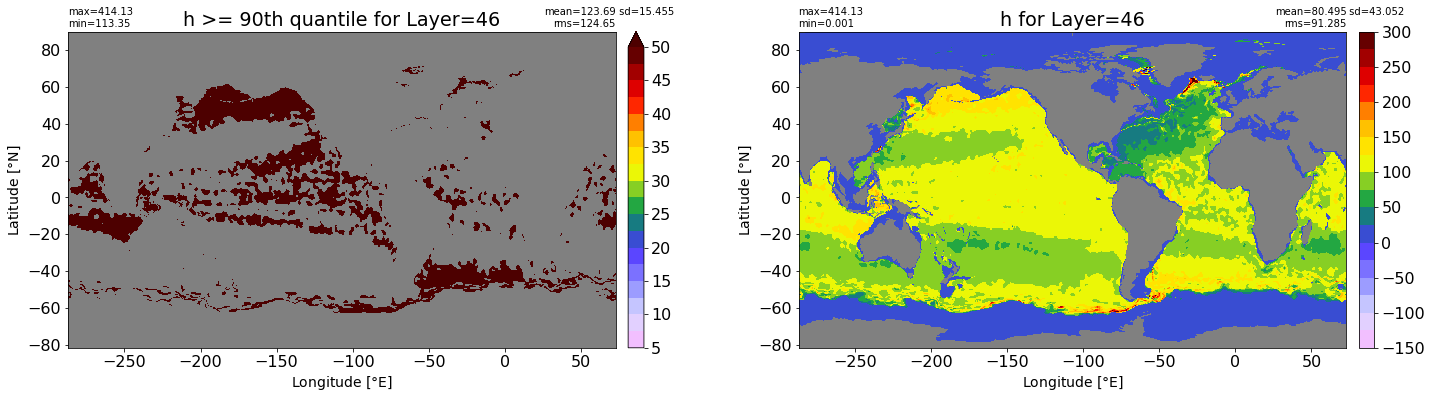

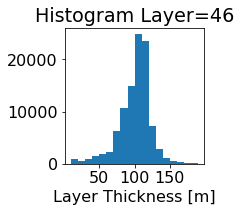

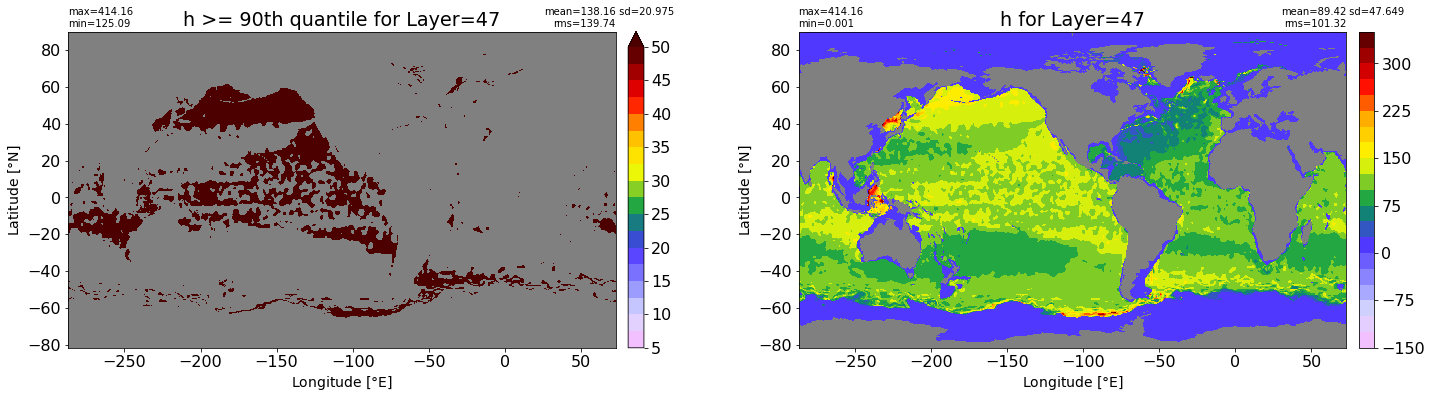

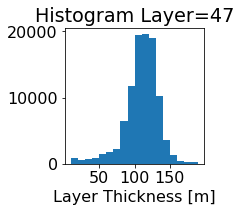

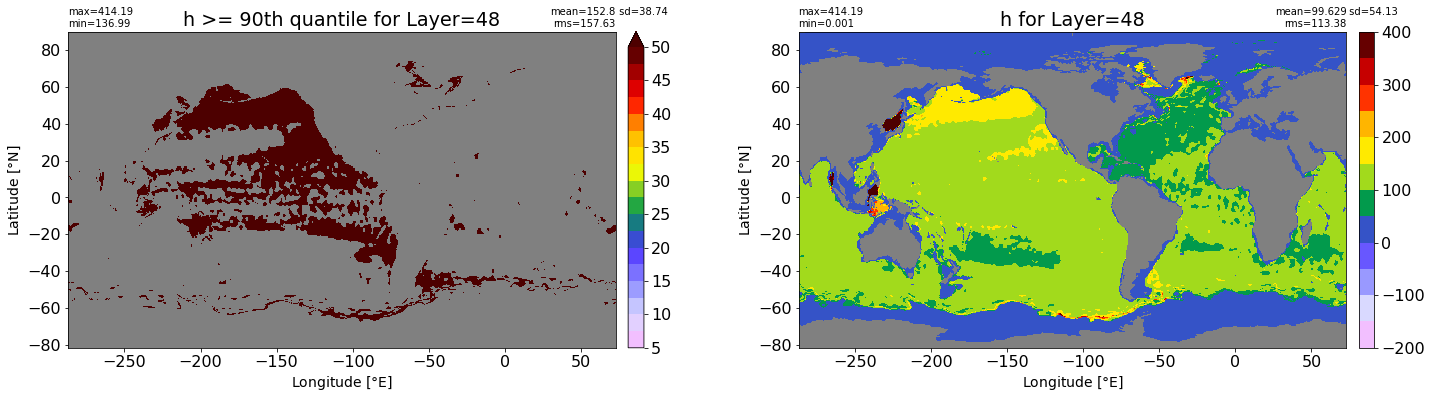

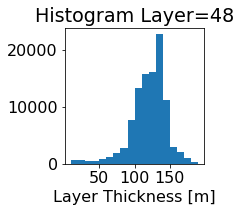

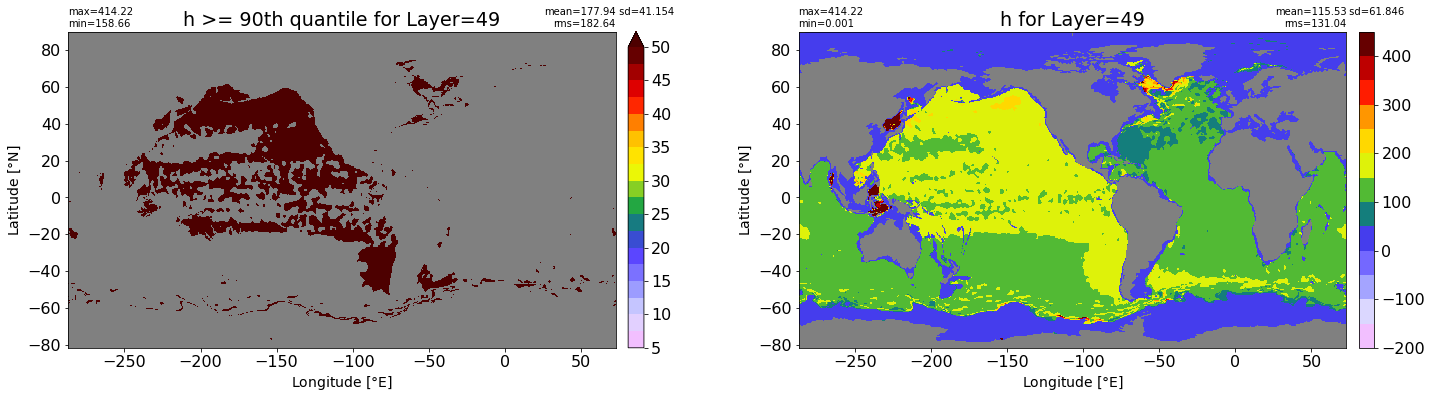

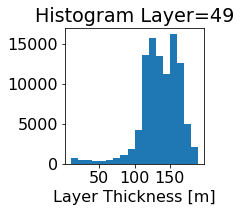

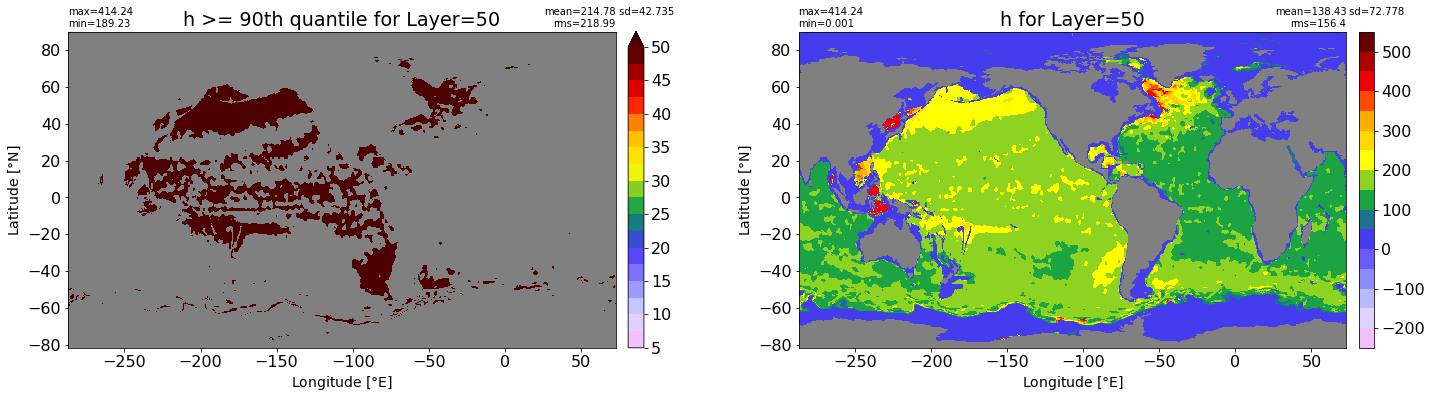

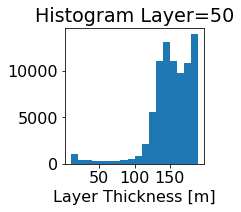

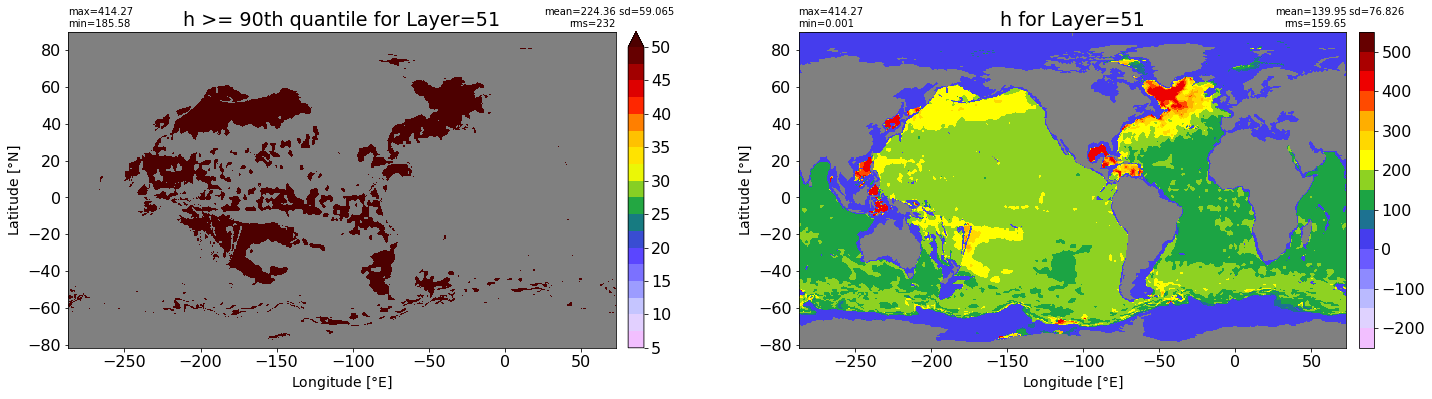

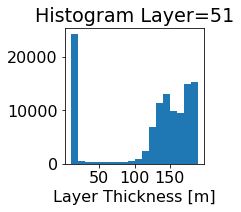

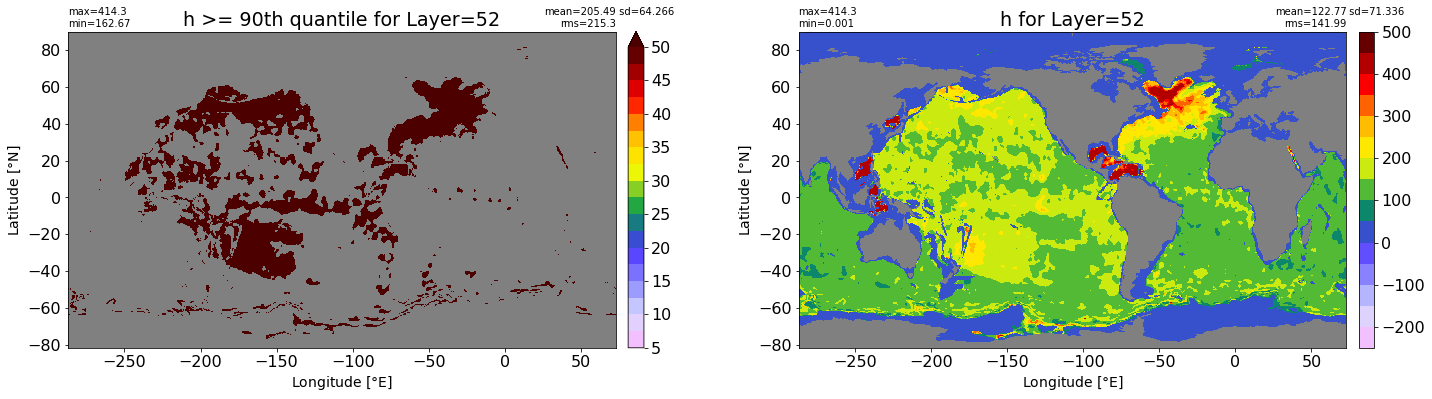

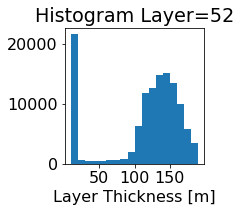

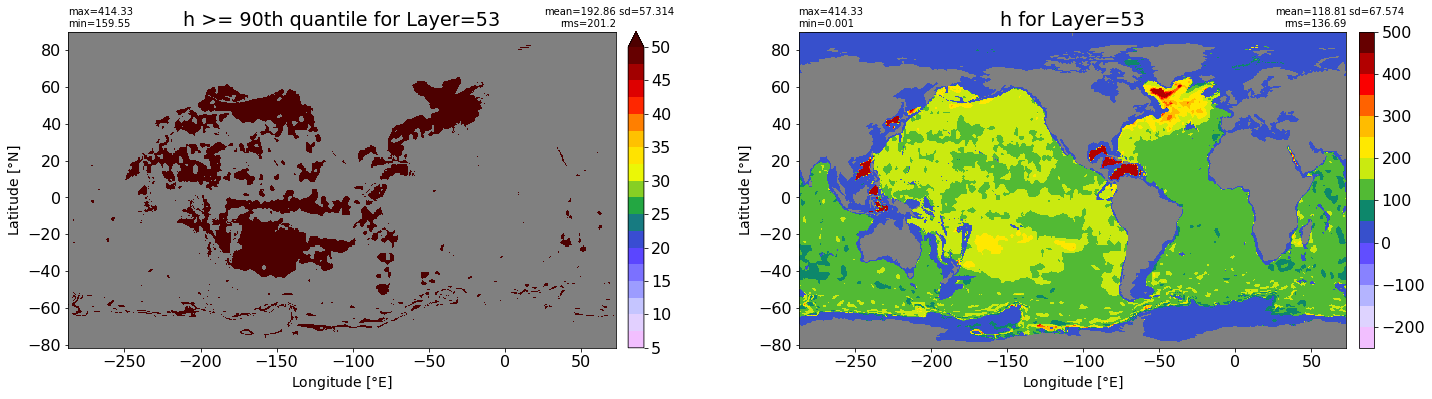

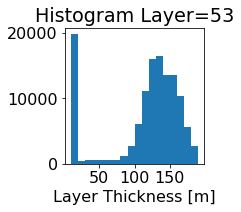

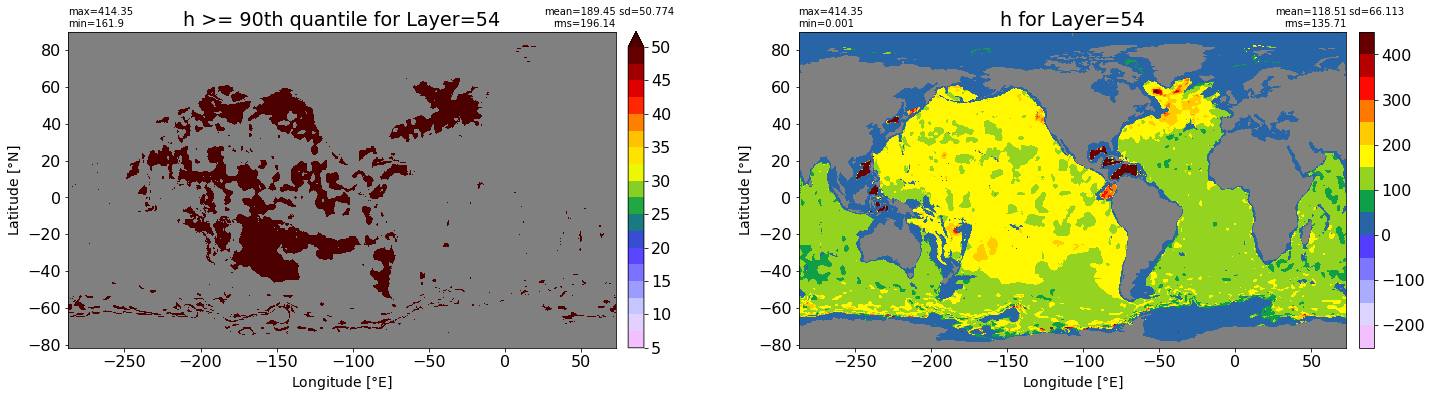

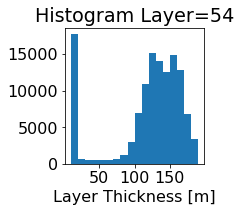

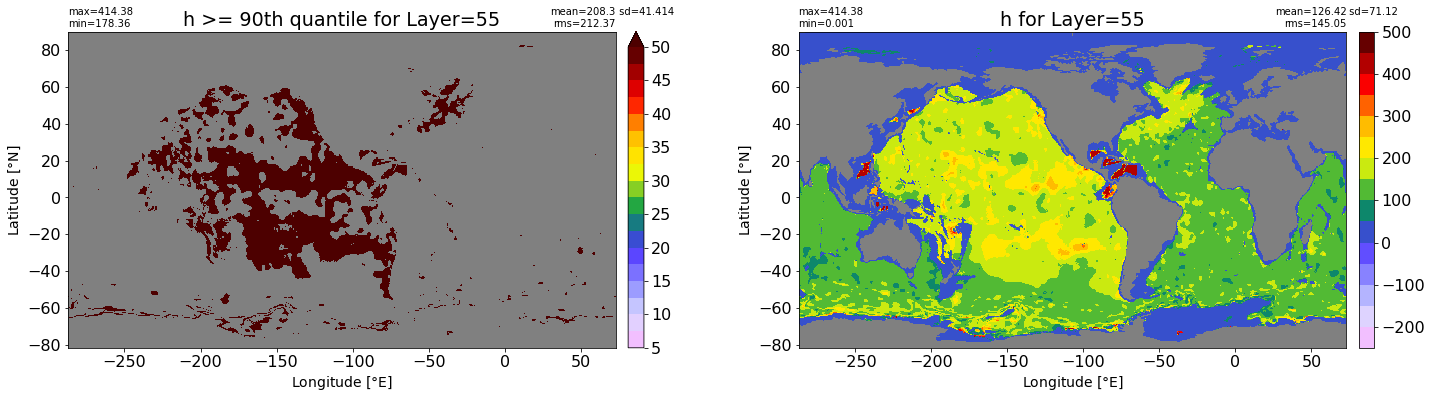

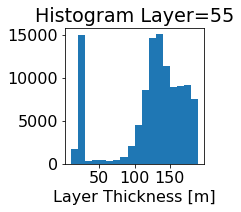

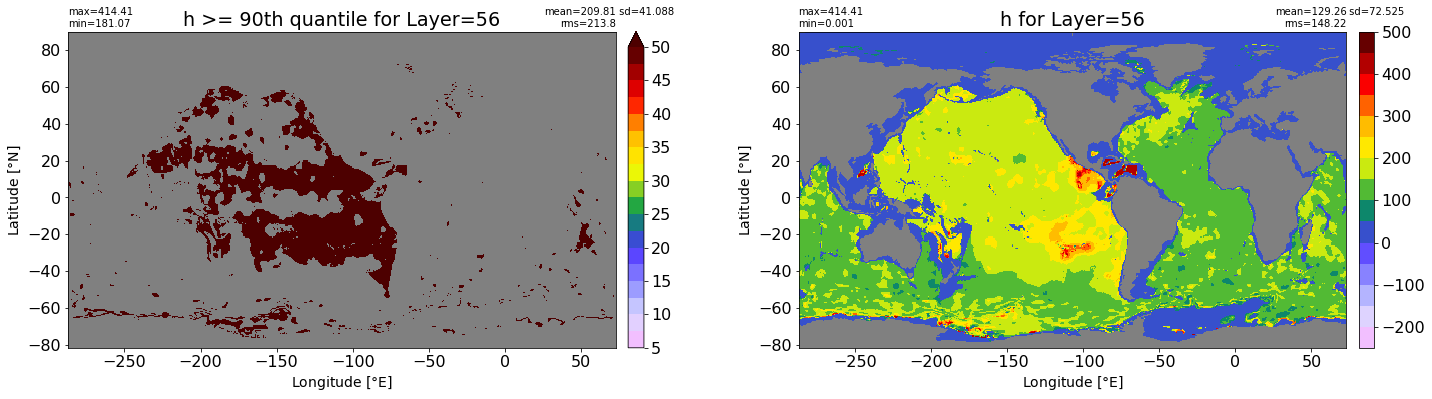

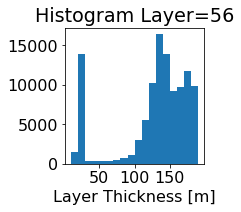

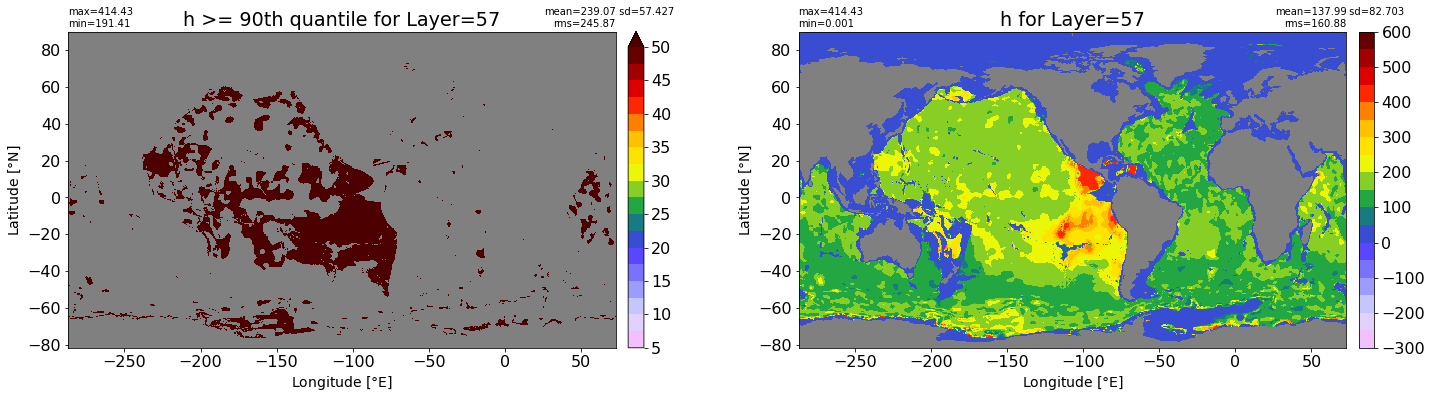

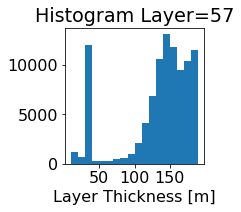

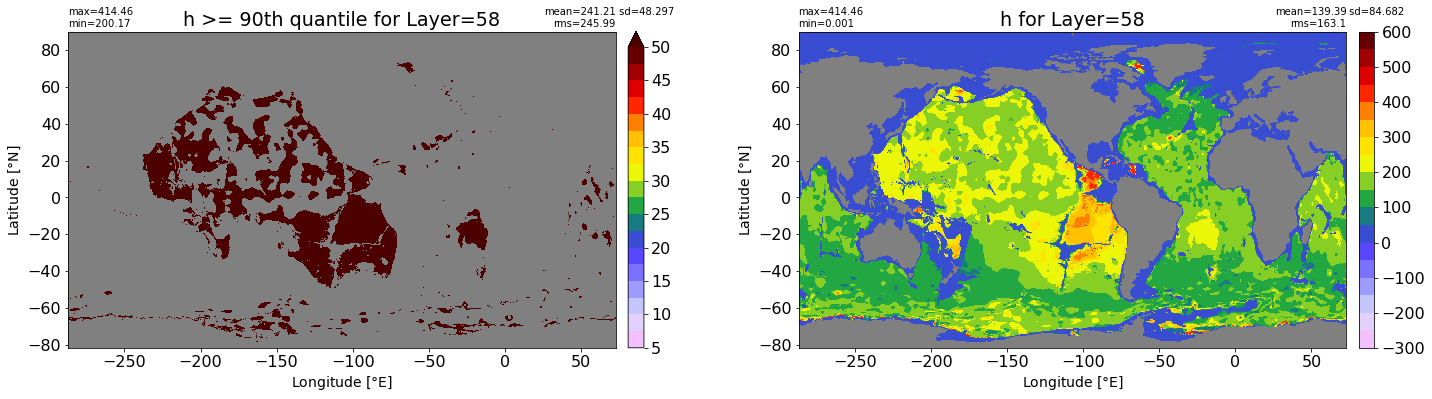

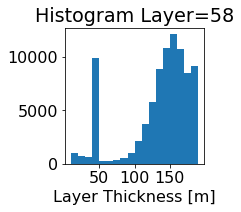

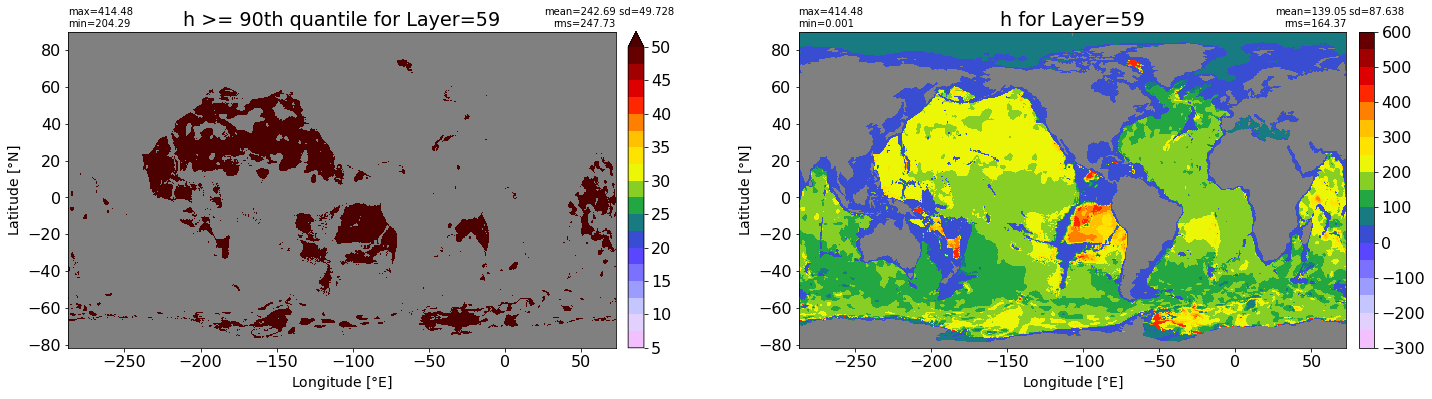

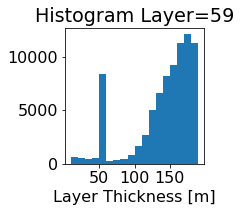

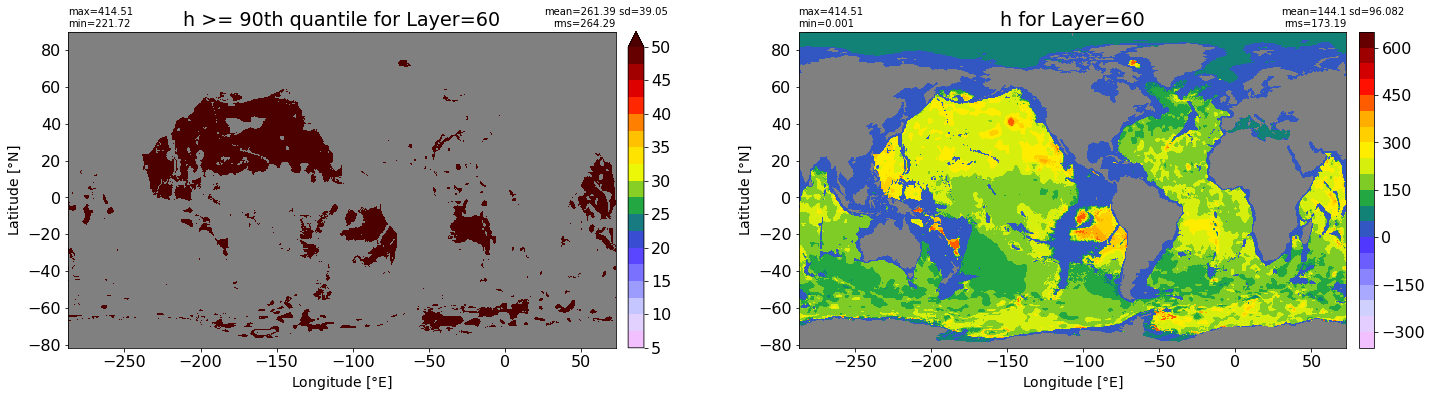

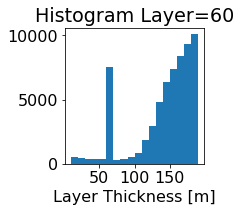

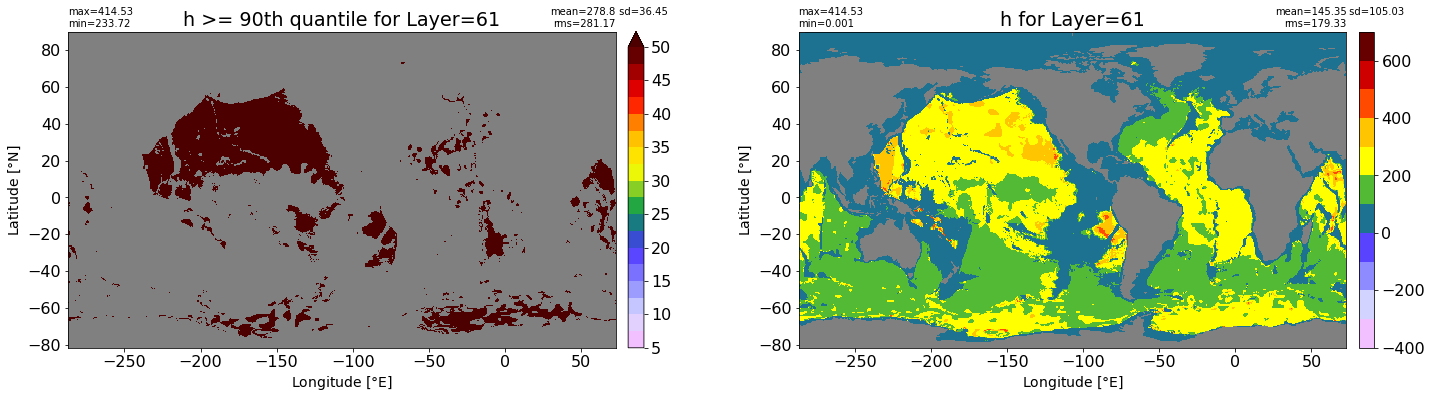

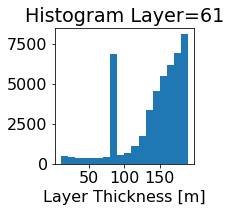

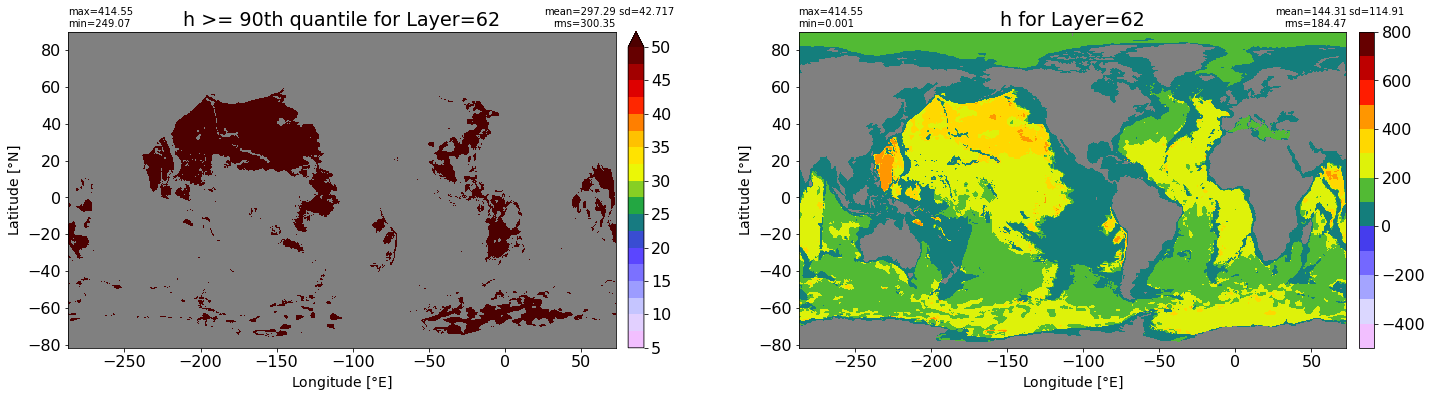

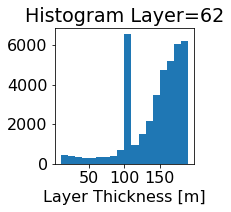

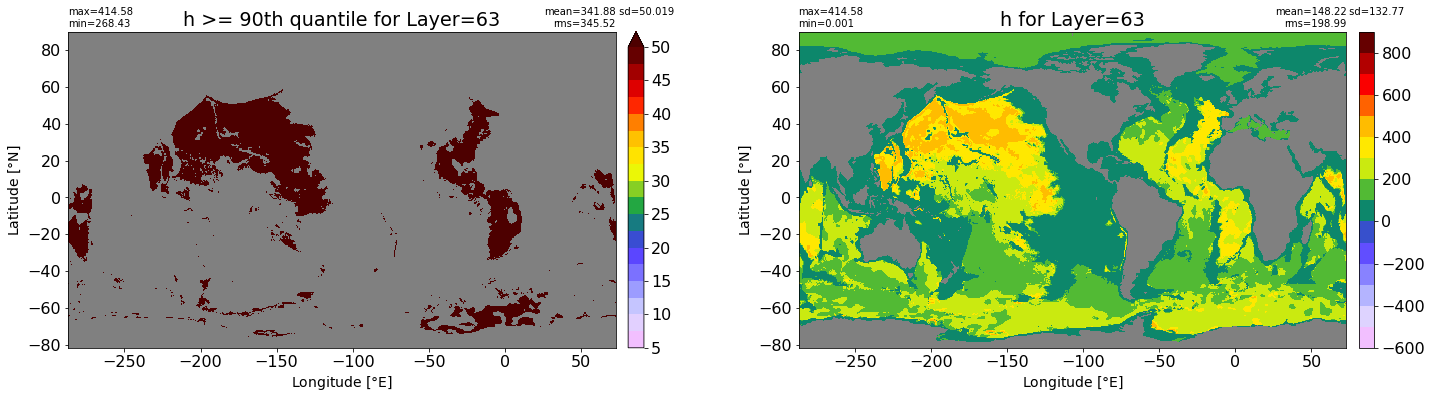

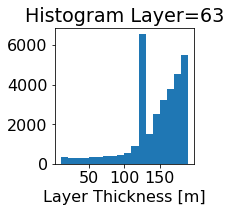

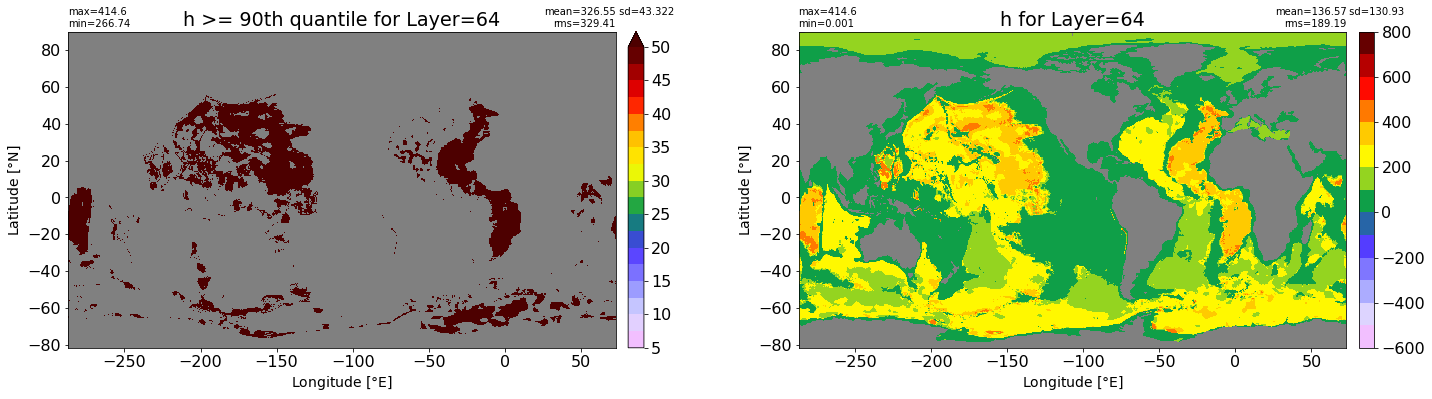

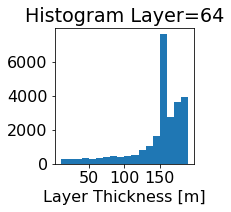

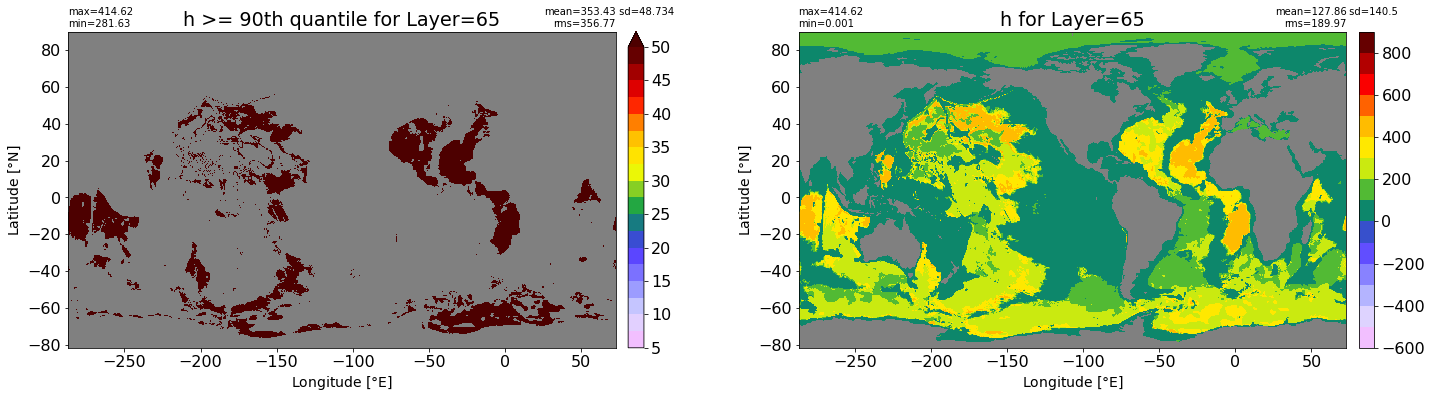

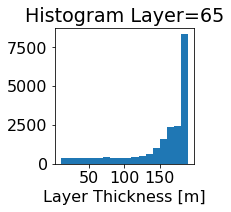

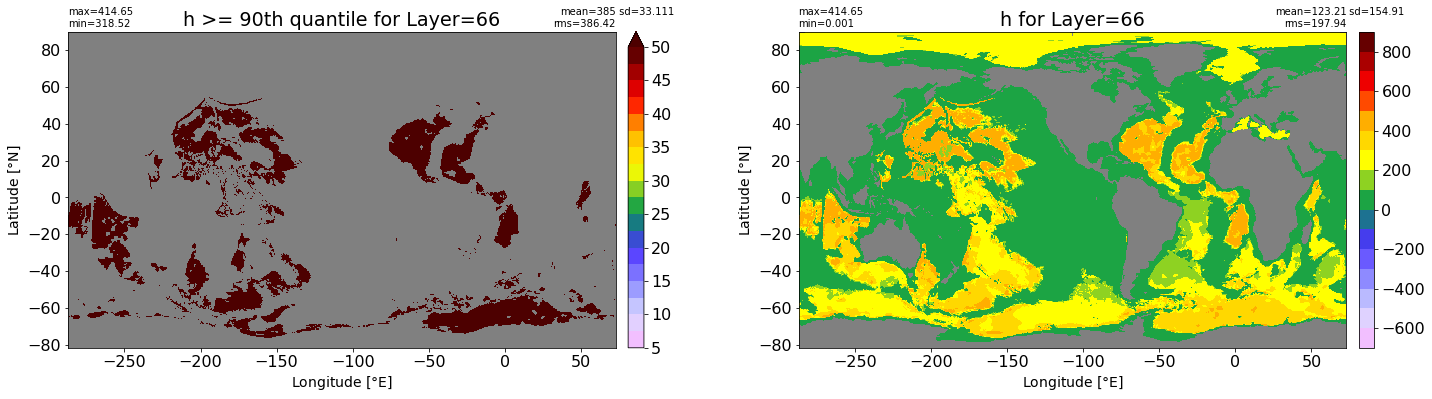

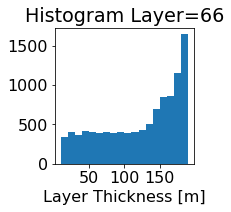

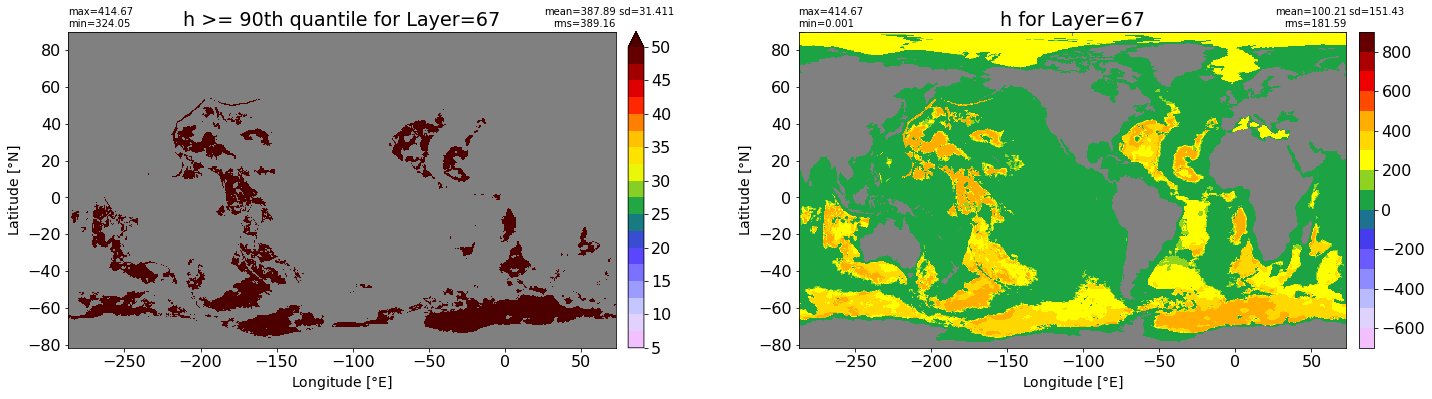

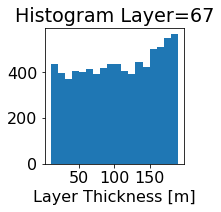

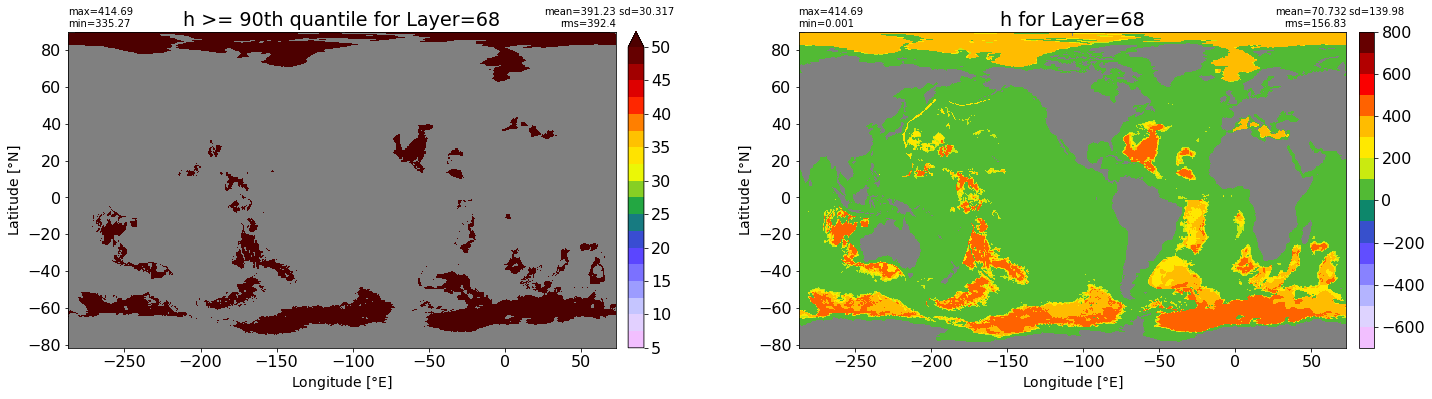

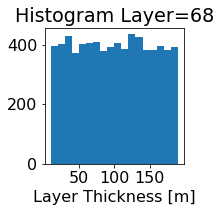

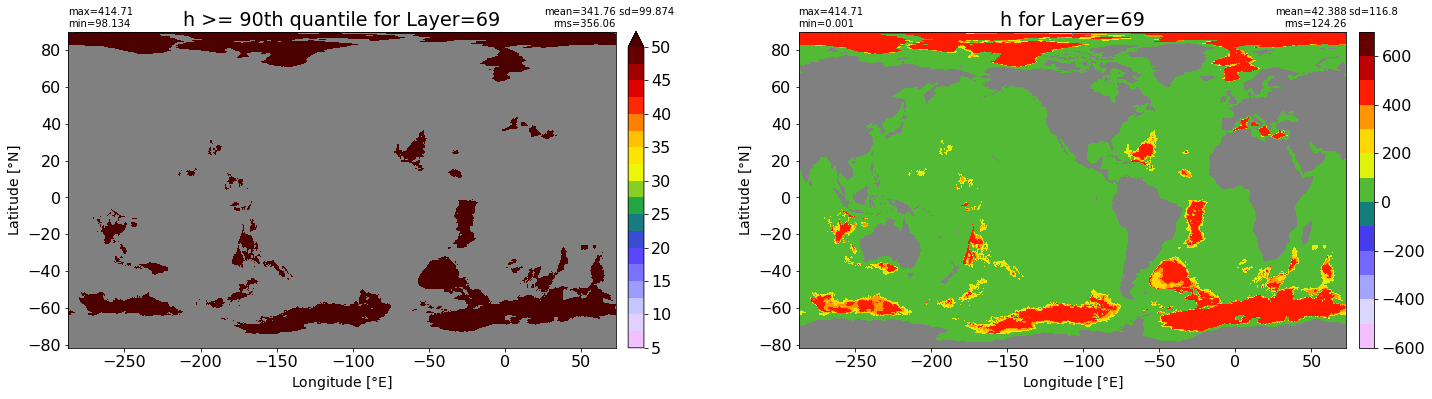

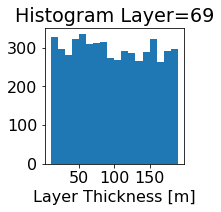

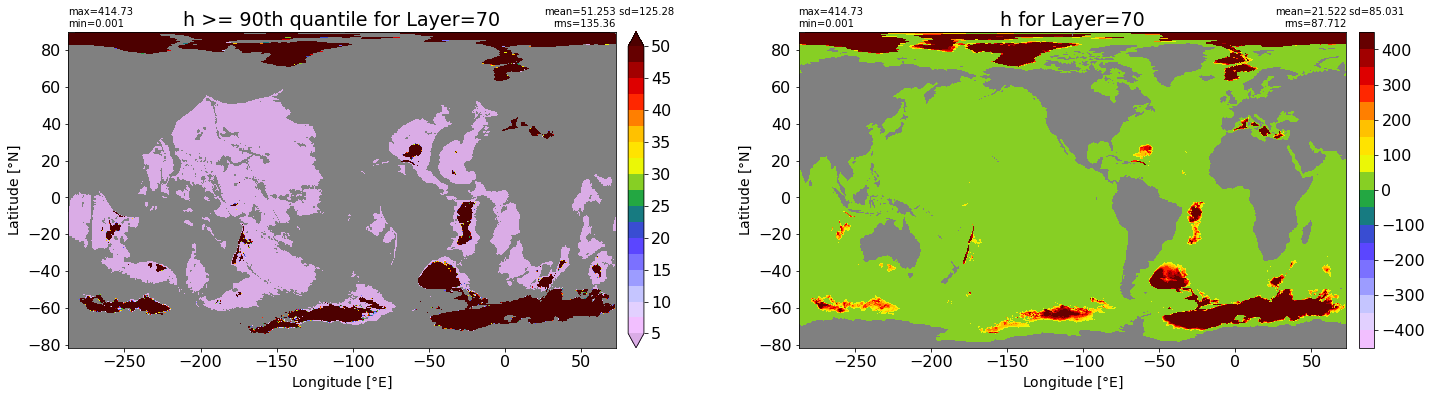

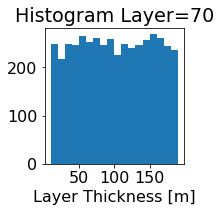

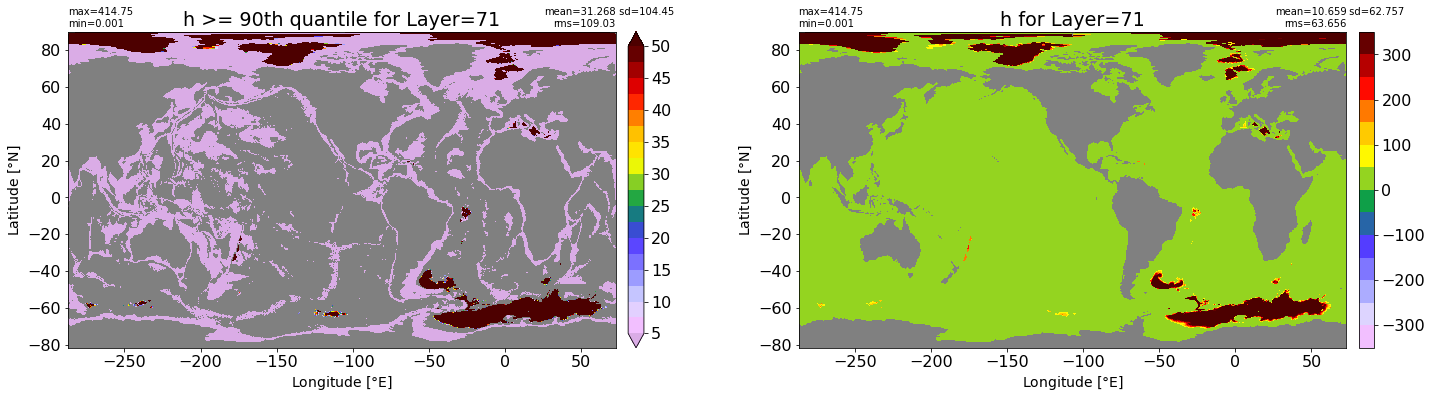

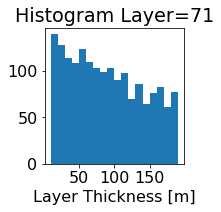

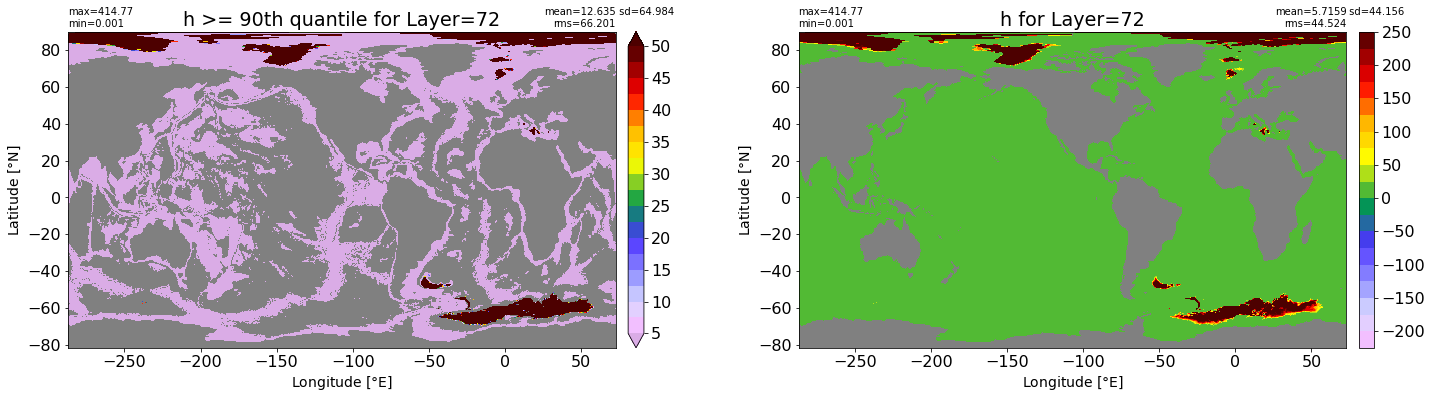

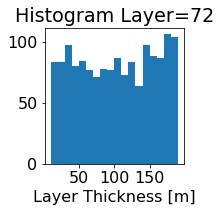

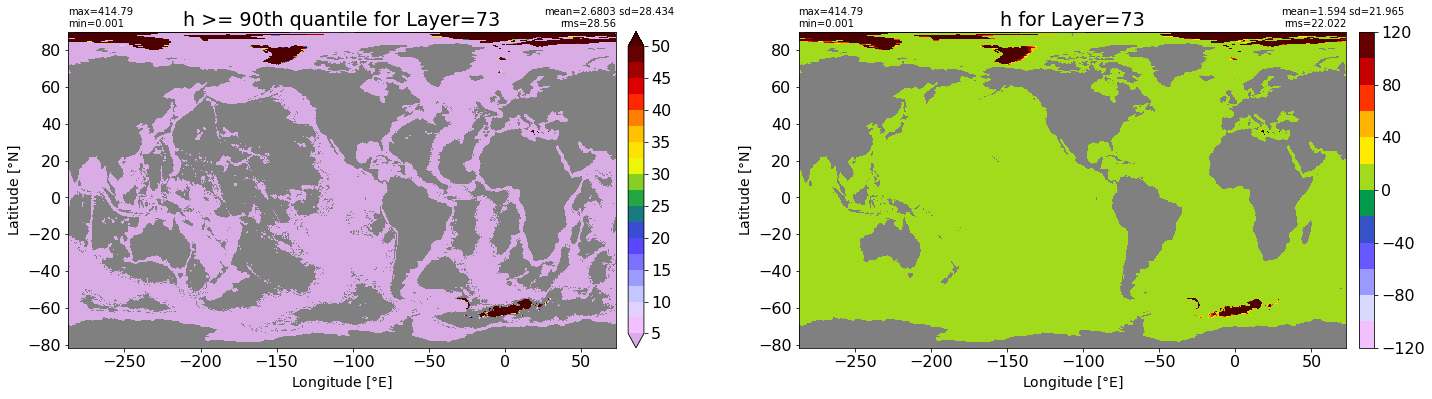

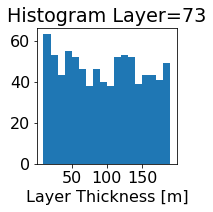

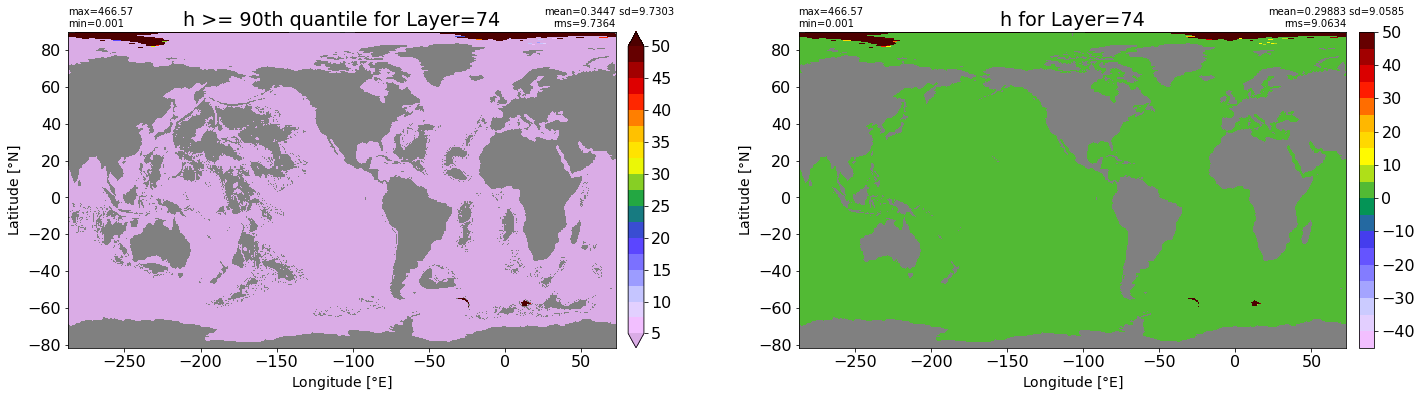

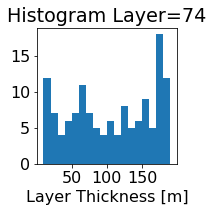

In [14]:
bins = np.arange(10, 200, 10)
Mean_90 = np.zeros(len(ics.Layer))
Std_90 = np.zeros(len(ics.Layer))
RMS_90 = np.zeros(len(ics.Layer))

for k in range(len(ics.Layer)):
#for k in range(20):

    data = get_quantile(ics.h[0,k,:], quantile=0.9, dims=['lath','lonh'])
    data1 = np.ma.masked_invalid(data.values)# * grd.wet.values
    Min, Max, Mean_90[k], Std_90[k], RMS_90[k] = myStats(data1, grd.area_t.values)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24,6.5))
    title1 = 'h >= 90th quantile for Layer={}'.format(k)
    xyplot(np.ma.masked_where(grd.wet.values == 0., data1), grd.geolon.values, grd.geolat.values, grd.area_t.values, title=title1, 
           clim=(5., 50.), axis=ax[0], nbins=20, sigma=5)
    title2 = 'h for Layer={}'.format(k)
    #data2 = np.ma.masked_invalid(ics.h[0,k,:].values) #* grd.wet.values
    
    data2 = ics.h[0,k,:].values
    xyplot(np.ma.masked_where(grd.wet.values == 0., data2), grd.geolon.values, grd.geolat.values, grd.area_t.values, title=title2, 
           axis=ax[1], nbins=20, sigma=5)
    plt.subplots_adjust(top = 0.8)

    fig, ax = plt.subplots(figsize=(2.5,2.5))
    ics.h[0,k,:].plot.hist(ax=ax, bins=bins)
    title3 = 'Histogram Layer={}'.format(k)
    ax.set_title(title3)

In [15]:
RMS_90

array([  2.49999987,   2.49999987,   2.64398286,   2.52906127,
         2.528046  ,   3.17002452,   2.82966101,   2.85044182,
         2.7335062 ,   2.78472144,   2.91840888,   3.14788992,
         5.91947574,   4.95183546,   5.549369  ,   6.73346407,
         7.57874192,  15.82926689,  14.50177195,  13.41650331,
        13.4654436 ,  13.72917385,  14.09291042,  15.78575757,
        17.89876773,  21.03573048,  25.23213729,  30.03095485,
        34.55386447,  34.90016546,  36.00712351,  37.10292082,
        44.87783535,  56.20806657,  63.58357165,  72.15017817,
        80.16838769,  94.40601621, 116.13228634, 114.70040409,
       129.6036234 , 131.76797368, 116.2640204 , 109.06462448,
       111.97581924, 117.84792669, 124.64797682, 139.74287665,
       157.62992308, 182.63635534, 218.98859406, 232.00104179,
       215.30296714, 201.19663676, 196.13597868, 212.3738024 ,
       213.79715404, 245.87368957, 245.99288766, 247.73433881,
       264.28649986, 281.17038354, 300.34660854, 345.52

### Define the function to fit (tanh)

In [16]:
def tanh_function(x, a, b, c, d):
    return a * np.tanh(b * x + c) + d

### Paste RMS_90 below and manually adjust small values near the bottom

In [17]:
# note the extra layers at the bottom
y = np.array([  2.49999987,   2.49999987,   2.64398286,   2.52906127,
         2.528046  ,   3.17002452,   2.82966101,   2.85044182,
         2.7335062 ,   2.78472144,   2.91840888,   3.14788992,
         5.91947574,   4.95183546,   5.549369  ,   6.73346407,
         7.57874192,  15.82926689,  14.50177195,  13.41650331,
        13.4654436 ,  13.72917385,  14.09291042,  15.78575757,
        17.89876773,  21.03573048,  25.23213729,  30.03095485,
        34.55386447,  34.90016546,  36.00712351,  37.10292082,
        44.87783535,  56.20806657,  63.58357165,  72.15017817,
        80.16838769,  94.40601621, 116.13228634, 114.70040409,
       129.6036234 , 131.76797368, 116.2640204 , 109.06462448,
       111.97581924, 117.84792669, 124.64797682, 139.74287665,
       157.62992308, 182.63635534, 218.98859406, 232.00104179,
       215.30296714, 201.19663676, 196.13597868, 212.3738024 ,
       213.79715404, 245.87368957, 245.99288766, 247.73433881,
       264.28649986, 281.17038354, 300.34660854, 345.52134604,
       329.40704216, 356.7702918 , 386.4174176 , 389.15544909,
       392.40018901, 356.05565569, 356.0, 356.0,
       356.0, 356.0, 356.0, 356.0, 356.0, 356.0, 356.0, 356.0,
       356.0, 356.0, 356.0, 356.0, 356.0, 356.0, 356.0, 356.0, 356.0, 356.0])

### Perform curve fitting

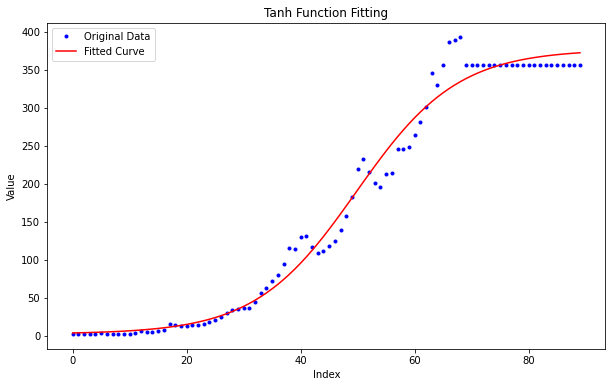

Optimized Parameters:
a = 187.08972100760633
b = 0.056399678180667163
c = -2.80764670977144
d = 189.62178708778868


In [20]:
x = np.arange(len(y))

popt, pcov = curve_fit(tanh_function, x, y)

# Extracting optimized parameters
a, b, c, d = popt

# Generate fitted curve
y_fit = tanh_function(x, a, b, c, d)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b.', label='Original Data')
plt.plot(x, y_fit, 'r-', label='Fitted Curve')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Tanh Function Fitting')
plt.legend()
plt.show()

# Printing optimized parameters
print("Optimized Parameters:")
print("a =", a)
print("b =", b)
print("c =", c)
print("d =", d)

In [21]:
dz_max_90 = tanh_function(range(len(dz)), a, b, c, d)

In [22]:
dz_max_90

array([  3.88978622,   4.05124971,   4.2318273 ,   4.43375969,
         4.65954471,   4.91196546,   5.19412109,   5.50946059,
         5.86181952,   6.25546   ,   6.69511391,   7.18602944,
         7.73402094,   8.34552182,   9.02764048,   9.78821859,
        10.63589128,  11.58014822,  12.63139452,  13.80100975,
        15.10140314,  16.54606232,  18.14959251,  19.92774221,
        21.89741083,  24.07663286,  26.4845323 ,  29.14124041,
        32.06776905,  35.28583156,  38.81760291,  42.68541118,
        46.91135357,  51.51683185,  56.52200507,  61.94516131,
        67.80201558,  74.1049473 ,  80.86219824,  88.07705989,
        95.74708725, 103.86338297, 112.41000134, 121.36352345,
       130.69285331, 140.35927768, 150.31682062, 160.51290687,
       170.8893278 , 181.38348107, 191.92983316, 202.46153511,
       212.91210815, 223.21710955, 233.31569094, 243.15197092,
       252.67615996, 261.84539616, 270.62427305, 278.98506237,
       286.90765387, 294.37924899, 301.39385482, 307.95

### Make sure max thickness of first 4 layers is 2.5 m

In [23]:
dz_max_90[0:4] = 2.5 # 
dz_max_90

array([  2.5       ,   2.5       ,   2.5       ,   2.5       ,
         4.65954471,   4.91196546,   5.19412109,   5.50946059,
         5.86181952,   6.25546   ,   6.69511391,   7.18602944,
         7.73402094,   8.34552182,   9.02764048,   9.78821859,
        10.63589128,  11.58014822,  12.63139452,  13.80100975,
        15.10140314,  16.54606232,  18.14959251,  19.92774221,
        21.89741083,  24.07663286,  26.4845323 ,  29.14124041,
        32.06776905,  35.28583156,  38.81760291,  42.68541118,
        46.91135357,  51.51683185,  56.52200507,  61.94516131,
        67.80201558,  74.1049473 ,  80.86219824,  88.07705989,
        95.74708725, 103.86338297, 112.41000134, 121.36352345,
       130.69285331, 140.35927768, 150.31682062, 160.51290687,
       170.8893278 , 181.38348107, 191.92983316, 202.46153511,
       212.91210815, 223.21710955, 233.31569094, 243.15197092,
       252.67615996, 261.84539616, 270.62427305, 278.98506237,
       286.90765387, 294.37924899, 301.39385482, 307.95

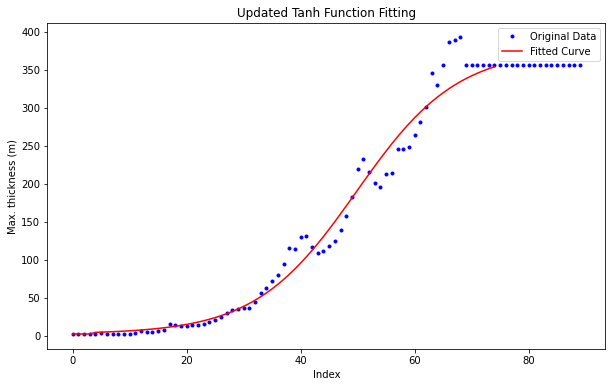

In [25]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b.', label='Original Data')
plt.plot(range(len(dz)), dz_max_90, 'r-', label='Fitted Curve')
plt.xlabel('Index')
plt.ylabel('Max. thickness (m)')
plt.title('Updated Tanh Function Fitting')
plt.legend()
plt.show()

### Save to file

In [26]:
ds = xr.Dataset(
    {"dz": dz_max_90},
    coords={
        'z': np.arange(len(dz_max_90)), 
    },
    attrs = {
        'long_name': 'Maximum thickness using h >= 90th quantile of run 018',
        'units'    : 'm',
        'author'   : author,
        'created'  : datetime.now().strftime("%Y-%d-%m %H:%M:%S")
    }
)
date_fmt = datetime.now().strftime("%Y")[-2:]+datetime.now().strftime("%d")+ \
           datetime.now().strftime("%m")
fname = 'dz_max_{}_{}.nc'.format(grid_name,date_fmt)
ds.to_netcdf(fname)